# Section 0: Preliminries

## Imports


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tqdm
import logging
from typing import Tuple, Dict, Any, List, Union, Optional, Callable

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from metrics import calculate_metrics, metrics_to_tabular_string

random_state = 42
np.random.seed(random_state)

In [33]:
# logging levels: DEBUG, INFO, WARNING, ERROR, CRITICAL
# change to logging.WARNING to reduce verbosity
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

## Introduction

<b>Chosen Topic: Strategic Classification (with some dynamics)</b>

Our project is about examining the dynamics that arise from strategic users who identify which features the model heavily weights/relies on (high average gradient, as we will see), the model's desire to retrain in order to overcome these strategic players and see where this system converges in terms of average features importance (average gradient of model scores w.r.t. features) and model accuracy.

Moreover, if we think of a dataset of loan requests, we'll also explore methods to leverage an assessment of the bank to evaluate the reliability of user features (such as income, etc.) in order to enhance models that are trained on data but tested in strategic environments.


## Hypotheses
In this notebook, we'll explore the following hypotheses:

A. The more a strategy is applied to a feature by users, the more the model will decrease the importance of this feature.

B. The more intensely users can change their features and the more users do so (including those far from the threshold), the more the model's performance will deteriorate over time and the feature importance vector will become more uniform.

C. If we define strategists to act within a model score range of [0.2, 0.5] for example, those under 0.2 will never use strategy over time, therefore model will classify them correctly as the dynamics continue, so model performance reamins pretty stable.

D. If users will also use strategies in the "non-important" features - the model can overcome the strategies in the important features by identifying the strategists that change the non-important features and lower their scores.

E. Models can be enhanced by utilizing their estimated reliability. 
For example, if we think again of a loans dataset, a bank knows that the credit score is a reliable feature, but asset value is more prone to strategic manipulation.

We will present different algorithms that utilize this info, some of which we implemented and tested.

- More Hypotheses that are related to the E Hypothesis are explained before conducting the experiment for convenience.

Some of our hypotheses are presented before certain experiments.


## How We Plan to Test Them

In this notebook, we will focus on impelementing relevant simulations.

It consists of three main types of simulations:

1. A dynamic environment where the model is trained, users below the threshold act strategically and the bank identifies the users who eventually returned the loan. This results in noisy features with true labels after which the model is retrained. We will show how feature importance and model performance change over time.

2. Analyzing how strategies can harm models, and in some cases, help them. For example, an aggressive strategy on a non-important feature will help the model identify strategists, as we will demonstrate in one of the experiments.

3. Implementing algorithms that utilize the estimated reliability of features (as evaluated by the bank) to improve the baseline model, transforming it into an informed model, and showing the improvements.


## Disclaimer

Attention! Each run might produce slightly different results.
Our explanations are true for all runs, but might use concrete values from a specific run, such as 5%, while it might be 3% in some other run.

# Section 1: Dataset and Models

## Dataset

We'll be using the [Loan-Approval-Prediction-Dataset](https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset?resource=download) dataset from kaggle.

The loan approval dataset is a collection of financial records and associated information used to determine the eligibility of individuals or organizations for obtaining loans from a lending institution. It includes various factors such as:

1. cibil score: The customer's credit card score.
2. income: The customer's income.
3. employment status: If the customer is self employed or not.
4. loan term: The duration for which the loan is taken, expressed in years.
5. loan amount.
6. Residential/Commercial/Bank/Luxury assets value
7. loan status: If the loan is approved or not. We can refer to this as whether the user managed to return the loan or not. Otherwise, we can't infer from the dataset about the "goodness" of users.

Before diving in, we'll explore the dataset to make it easier for the reader to get an overall intuition.


In [34]:
# Load the dataset
input_dir = "./kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv"
loan_original = pd.read_csv(input_dir)

loan_original.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


As we can see, there are strings in the data. We'll transform the dataset so we can apply learning algorithms on it.


In [35]:
# columns have weird spaces in names:
loan_original.columns = loan_original.columns.str.replace(" ", "")
loan_original[loan_original["loan_id"].duplicated(keep=False) == True].sort_values(
    ["loan_id"]
)
# remove the loan_id column
loan_ds = loan_original.drop(["loan_id"], axis=1)

# replace all spaces in loan_status and education and self_employed columns to ""
loan_ds["loan_status"] = loan_ds["loan_status"].str.replace(" ", "")
loan_ds["education"] = loan_ds["education"].str.replace(" ", "")
loan_ds["self_employed"] = loan_ds["self_employed"].str.replace(" ", "")

GRADUATE_STRING = loan_ds["education"].unique()[0]
NOT_GRADUATE_STRING = loan_ds["education"].unique()[1]
# make education column binary
loan_ds["education"] = loan_ds["education"].apply(
    lambda x: 1 if x == GRADUATE_STRING else 0
)

APPROVED_STRING = loan_ds["loan_status"].unique()[0]
REJECTED_STRING = loan_ds["loan_status"].unique()[1]
# make loan_status column binary
loan_ds["loan_status"] = loan_ds["loan_status"].apply(
    lambda x: 1 if x == APPROVED_STRING else 0
)

YES_STRING = loan_ds["self_employed"].unique()[1]
NO_STRING = loan_ds["self_employed"].unique()[0]
# make self_employed column binary
loan_ds["self_employed"] = loan_ds["self_employed"].apply(
    lambda x: 1 if x == YES_STRING else 0
)

loan_ds.describe(include="all")

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,4269.000000,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4269.000000
mean,2.498712,0.502225,0.503631,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06,0.622160
std,1.695910,0.500054,0.500045,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06,0.484904
min,0.000000,0.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00,0.000000
25%,1.000000,0.000000,0.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06,0.000000
50%,3.000000,1.000000,1.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06,1.000000
75%,4.000000,1.000000,1.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06,1.000000
max,5.000000,1.000000,1.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07,1.000000


In [36]:
loan_ds["loan_status"].value_counts()

loan_status
1    2656
0    1613
Name: count, dtype: int64

In [37]:
loan_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   no_of_dependents          4269 non-null   int64
 1   education                 4269 non-null   int64
 2   self_employed             4269 non-null   int64
 3   income_annum              4269 non-null   int64
 4   loan_amount               4269 non-null   int64
 5   loan_term                 4269 non-null   int64
 6   cibil_score               4269 non-null   int64
 7   residential_assets_value  4269 non-null   int64
 8   commercial_assets_value   4269 non-null   int64
 9   luxury_assets_value       4269 non-null   int64
 10  bank_asset_value          4269 non-null   int64
 11  loan_status               4269 non-null   int64
dtypes: int64(12)
memory usage: 400.3 KB


By the data cleaning scans, we have confirmed:

1. There is no null value and duplicated value in this dataset.
2. `no_of_dependents`, `education`, `self_employed` and `loan_status` are categorical columns.
3. There are a total 4269 rows in this dataset, with 11 features and 1 target label.
4. There are 2656 data with an approved `loan_status`, which is about 62.2% compared to the "rejected" group. The dataset is slightly imbalanced but it is acceptable and we don't need to rebalance it.
5. Other columns are numerical.


## Dataset Explorations and Features Relations


We'll also show the correlation matrix as it's always useful to do so.


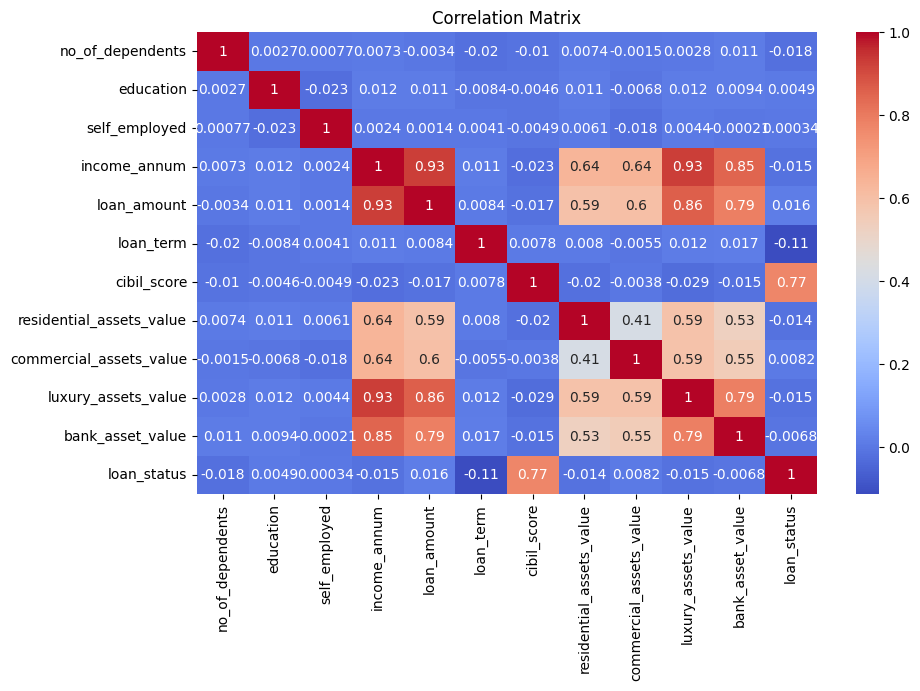

In [38]:
# corr and sns.heatmap
corr = loan_ds.corr()
plt.figure(figsize=(10, 6))

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

We can see that cibil_score and loan_status have a high correlation. This means that the cibil_score is a good predictor of loan_status.


We'll try and see if there're some "important" features that directly affect the loan_status (Approved/Rejected).


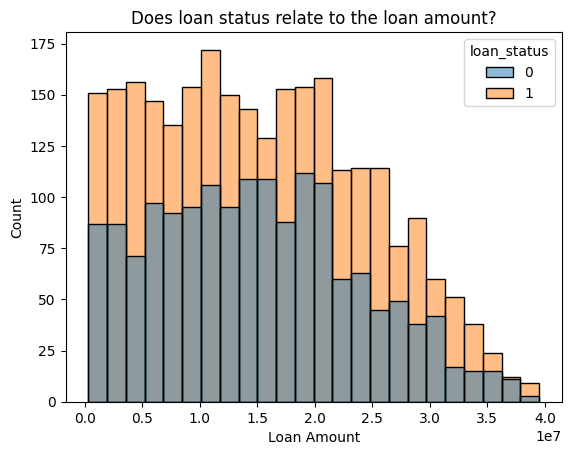

In [39]:
sns.histplot(loan_ds, x="loan_amount", hue="loan_status")
plt.title("Does loan status relate to the loan amount?")
plt.xlabel("Loan Amount")
plt.ylabel("Count")
plt.show()

We can see that loan amount does not affect the loan status.


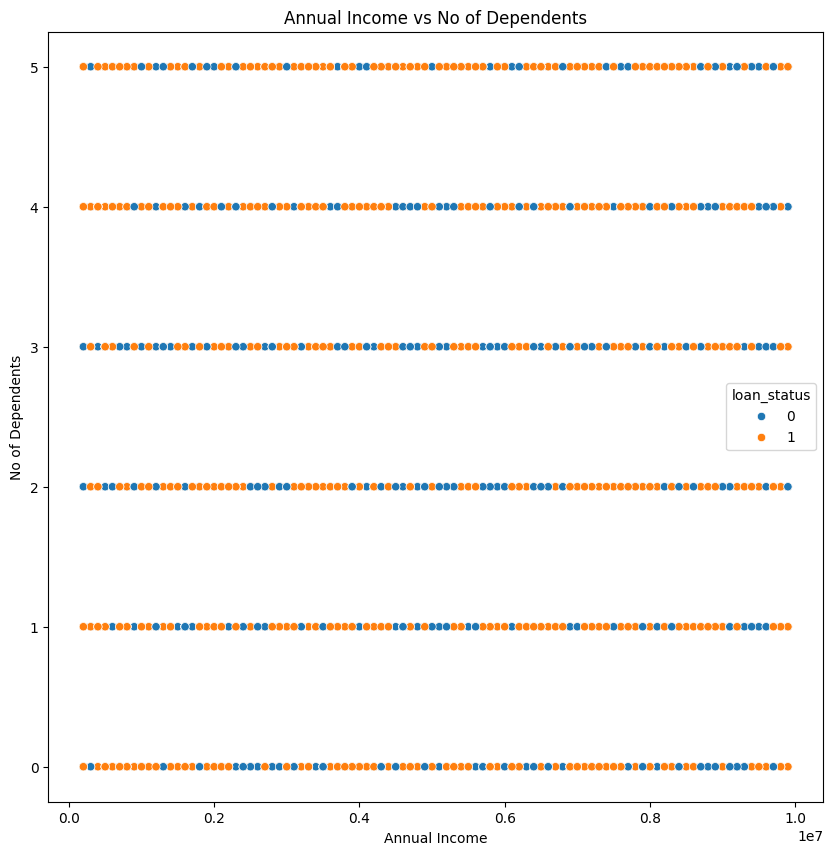

In [40]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=loan_ds, x="income_annum",
                y="no_of_dependents", hue="loan_status")
plt.title("Annual Income vs No of Dependents")
plt.xlabel("Annual Income")
plt.ylabel("No of Dependents")
plt.show()

We can see that num of dependents and annual income are not very effective in predicting loan status.


INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


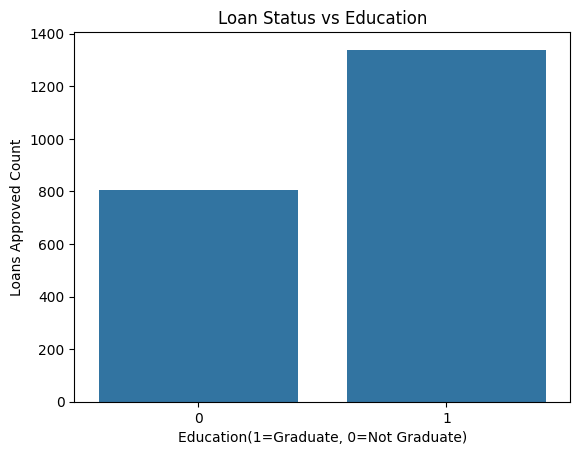

In [41]:
sns.countplot(data=loan_ds[loan_ds["education"] == 1], x="loan_status")
plt.title("Loan Status vs Education")
plt.xlabel("Education(1=Graduate, 0=Not Graduate)")
plt.ylabel("Loans Approved Count")
plt.show()

We can see the binary "Education" feature is somewhat informative to predict loan status.


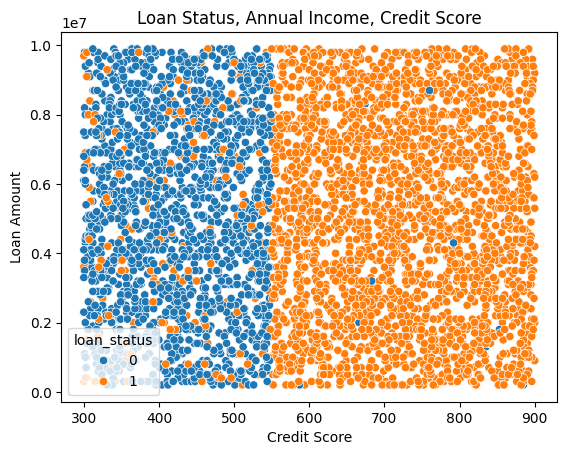

In [42]:
sns.scatterplot(
    x=loan_ds["cibil_score"], y=loan_ds["income_annum"], hue=loan_ds["loan_status"]
)
plt.title("Loan Status, Annual Income, Credit Score")
plt.xlabel("Credit Score")
plt.ylabel("Loan Amount")
plt.show()

As can be seen, it seems that the data is kind of separable in terms of Credit Score as it appears there's some threshold. Let's try and implement a naive model that classifies the data according to this threshold.


In [43]:
def acc_for_column_threshold(
    df,
    feature_column,
    threshold,
    target_column,
    target_value_below_thresh,
    target_value_above_thresh,
):
    df_thresh = df.copy()
    # remove all cols except feature_column and target_column
    df_thresh = df_thresh[[feature_column, target_column]]
    # create new column with thresholded values
    df_thresh["thresh_pred"] = df_thresh[feature_column] >= threshold
    # change True/False to target values
    df_thresh["thresh_pred"] = df_thresh["thresh_pred"].replace(
        {True: target_value_above_thresh, False: target_value_below_thresh}
    )
    # calculate accuracy
    acc = accuracy_score(df_thresh[target_column], df_thresh["thresh_pred"])
    return df_thresh, acc

In [44]:
threshold = 540
df_thresh, acc = acc_for_column_threshold(
    loan_ds, "cibil_score", threshold, "loan_status", 0, 1
)
print(f"Accuracy for cibil_score threshold {threshold}: ", acc)

Accuracy for cibil_score threshold 540:  0.9355821035371281


/var/folders/6q/cv5n11q16_g3rwq7b_g5fjnc0000gp/T/ipykernel_1073/1541882033.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_thresh["thresh_pred"] = df_thresh["thresh_pred"].replace(


We see that we get 0.93 accuracy, which is impressive since as we've mentioned the data is not imbalanced. If the data is imbalanaced say, 90% of loans are approved, a stupied classifier that always says 'Yes' would get 90% accuracy. But this is not our case.

In the future we will manually change this dataset so it will have more informative features, and decrease the informativity of the cibil_score feature.


## Training Different Models


In [45]:
# Basic parameters
default_batch_size = 64
default_test_size = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Splitting the dataset into features and target
X = loan_ds.drop("loan_status", axis=1).values
y = loan_ds["loan_status"].values

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=default_test_size, random_state=random_state
)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
class MLPModel(nn.Module):
    def __init__(self, input_size, layers_sizes):
        super(MLPModel, self).__init__()
        self.layers = nn.ModuleList()
        for i, layer_size in enumerate(layers_sizes):
            if i == 0:
                self.layers.append(nn.Linear(input_size, layer_size))
            else:
                self.layers.append(nn.Linear(layers_sizes[i - 1], layer_size))
            self.layers.append(nn.ReLU(inplace=True))
        self.layers.append(nn.Linear(layers_sizes[-1], 1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return torch.sigmoid(x)


class Conv1DModel(nn.Module):
    def __init__(self, input_size, output_channels=16, kernel_size=3):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(
            1, output_channels, kernel_size=kernel_size, padding=1)
        self.fc1 = nn.Linear(
            output_channels * ((input_size + 2 * 1 - kernel_size) // 1 + 1), 64
        )
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Assuming x has shape (batch_size, input_size), we need to unsqueeze to (batch_size, 1, input_size) for Conv1D
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        # Flatten the output for the dense layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [47]:
# Helper functions to create a PyTorch dataset and dataloader
def prepare_data(
    loan_ds,
    test_size=default_test_size,
    random_state=random_state,
    batch_size=default_batch_size,
):
    # Splitting the dataset into features and target
    X = loan_ds.drop("loan_status", axis=1).values
    y = loan_ds["loan_status"].values

    # Splitting into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Standardizing the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Converting to PyTorch tensors
    X_torch_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_torch_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)

    y_torch_train = torch.tensor(y_train, dtype=torch.float32)
    y_torch_test = torch.tensor(y_test, dtype=torch.float32)

    # Creating datasets and dataloaders
    train_dataset = TensorDataset(X_torch_train_scaled, y_torch_train)
    test_dataset = TensorDataset(X_torch_test_scaled, y_torch_test)

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False)

    return X_torch_train_scaled, X_torch_test_scaled, train_loader, test_loader


def get_names_to_new_models(input_size):
    """
    This function generates some of the models we will work with.
    MLP in different sizes, the layers sizes shown in the list.
    And a conv1D model, which is like a convnet in 2D, but in 1D.
    """

    return {
        "Small MLP": MLPModel(input_size, [32, 16]),
        "Medium MLP": MLPModel(input_size, [64, 32, 16]),
        "Large MLP": MLPModel(input_size, [128, 64, 32, 16]),
        "Conv1D": Conv1DModel(input_size),  # Conv1D model
    }


def train_and_evaluate_pytorch_model(
    threshold,
    model,
    model_name,
    train_loader,
    test_loader,
    epochs=100,
    lr=0.001,
    return_logits=False,
):
    """
    This function trains and evaluates a PyTorch model.
    It returns the model, model name, metrics, and optionally the logits and labels."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Training loop
    model.train()
    for epoch in tqdm.tqdm(range(epochs), desc=f"Training {model_name}"):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            all_labels.extend(labels.numpy())
            all_outputs.extend(outputs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)
    metrics = calculate_metrics(all_labels, all_outputs, threshold)
    if return_logits:
        return {
            "model": model,
            "model_name": model_name,
            "metrics": metrics,
            "logits": all_outputs,
            "all_labels": all_labels,
        }
    return {
        "model": model,
        "model_name": model_name,
        "metrics": metrics,
    }


def compare_torch_models(model_results, metrics):
    """
    This function compares the results of different models.
    It plots the metrics for each model.
    """
    model_metrics = {}
    model_names = {}
    for metric in metrics:
        model_metrics[metric] = [result["metrics"][metric]
                                 for result in model_results]
        model_names[metric] = [result["model_name"]
                               for result in model_results]

    # Plotting
    width = 0.35  # the width of the bars
    num_metrics = len(metrics)

    # If only one metric, make sure ax is iterable
    if num_metrics == 1:
        fig, ax = plt.subplots(figsize=(14, 6))
        ax = [ax]
    else:
        fig, ax = plt.subplots(num_metrics, 1, figsize=(14, 6 * num_metrics))

    colors = ["orange", "blue", "green", "red"]

    for i, metric in enumerate(metrics):
        x = np.arange(len(model_names[metric]))  # the label locations
        rects = ax[i].bar(
            x, model_metrics[metric], width, label=metric, color=colors[i % len(
                colors)]
        )
        # Show the number on the bars
        for rect in rects:
            height = rect.get_height()
            ax[i].annotate(
                f"{height:.4f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )
        ax[i].set_ylabel("Scores")
        ax[i].set_title(f"Model {metric} Comparison")
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(model_names[metric])
        ax[i].legend()

    fig.tight_layout()
    plt.show()

Get the results of the different models using the helper functions above.


In [48]:
X_torch_train_scaled, X_torch_test_scaled, train_loader, test_loader = prepare_data(
    loan_ds
)
input_size = X_torch_train_scaled.shape[1]
names_to_models = get_names_to_new_models(input_size)
threshold = 0.5

torch_models_results = []
for model_name, model in names_to_models.items():
    model = model.to(device)
    result = train_and_evaluate_pytorch_model(
        threshold, model, model_name, train_loader, test_loader
    )
    torch_models_results.append(result)

Training Conv1D: 100%|██████████| 100/100 [00:09<00:00, 11.04it/s]


Compare the different torch models in terms of accuracy and f1_score.


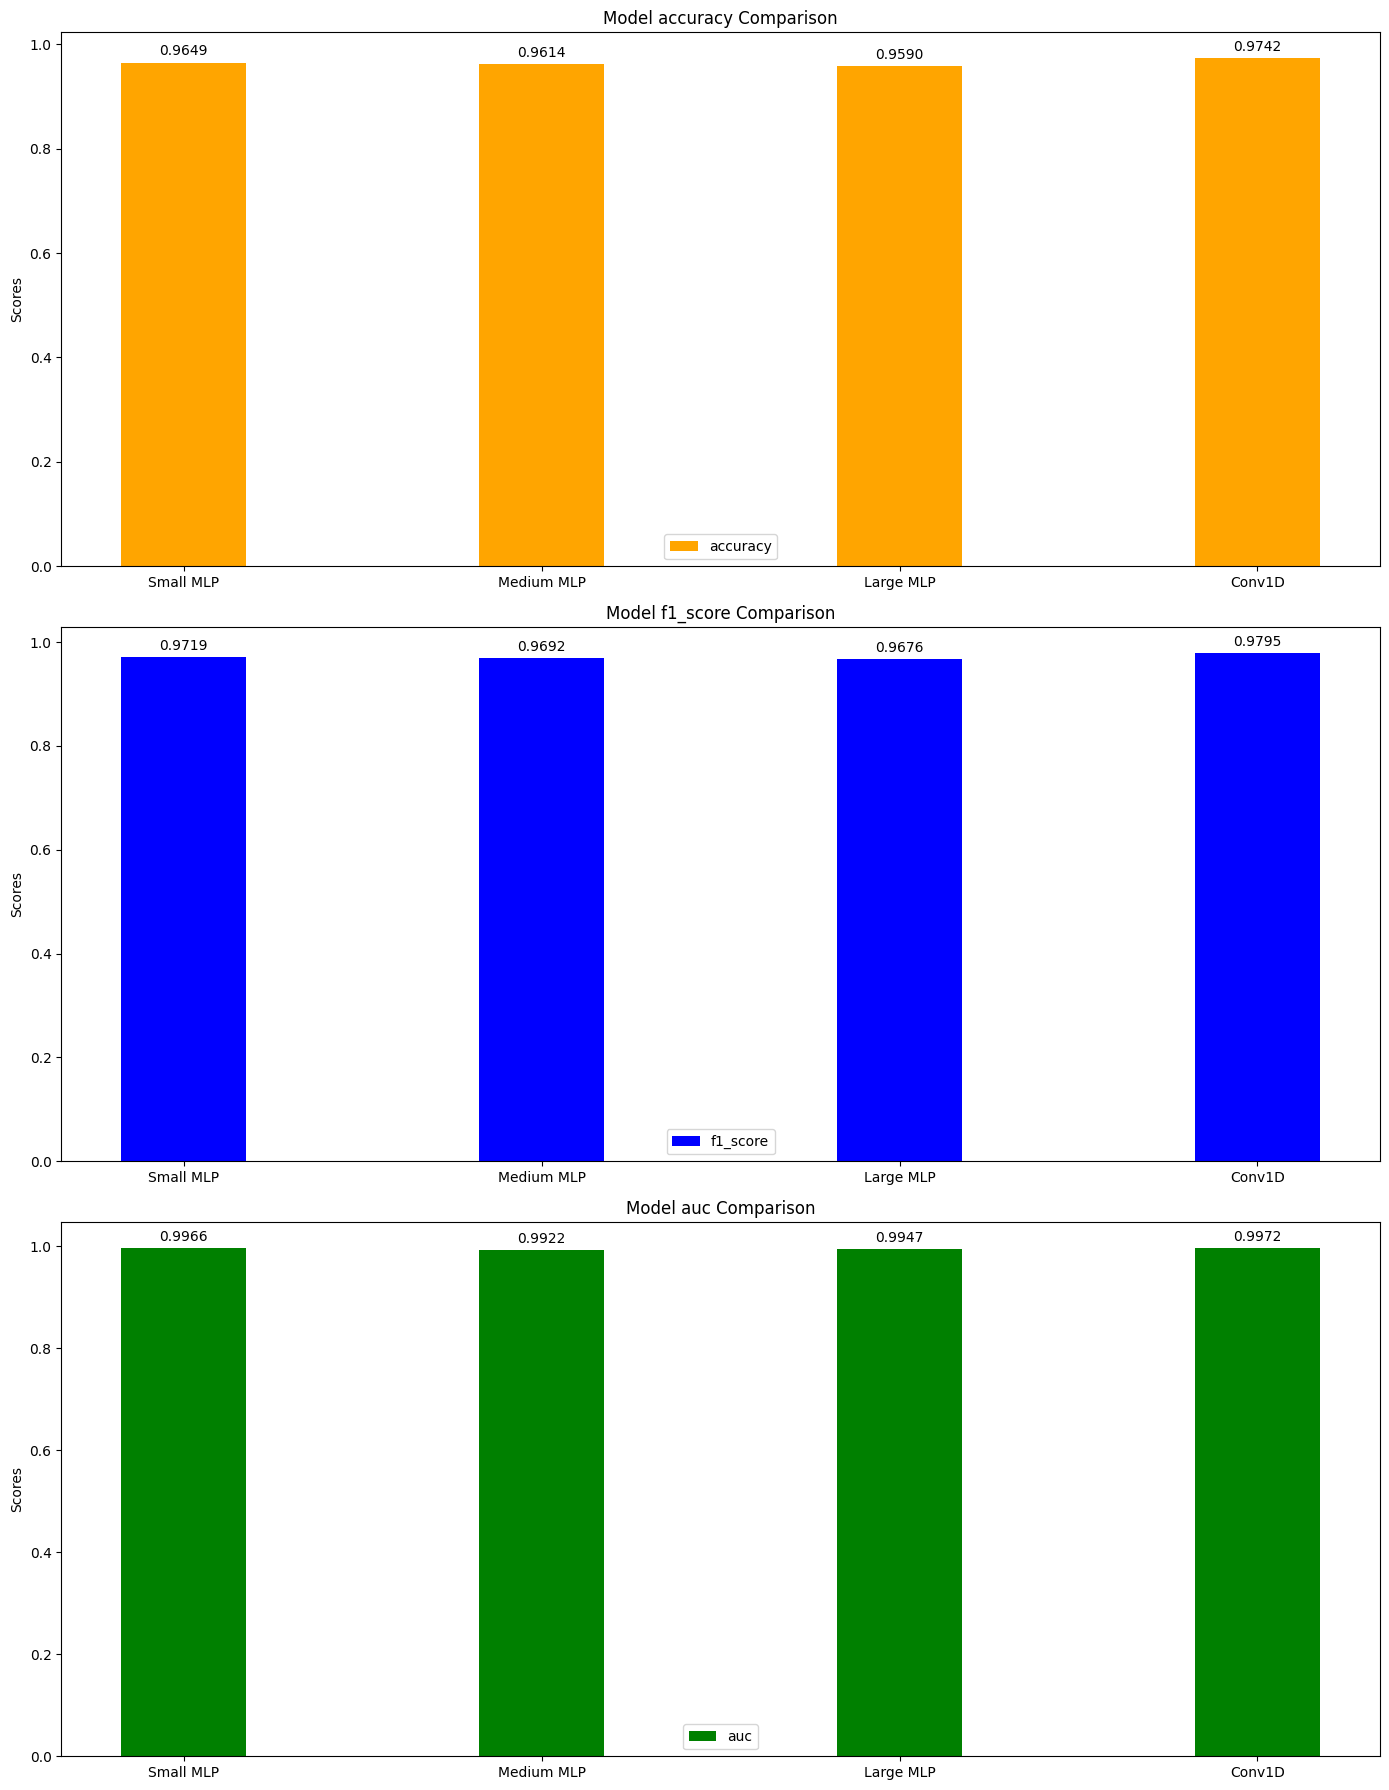

In [49]:
compare_torch_models(torch_models_results, ["accuracy", "f1_score", "auc"])

It's evident that all models get very good results for the dataset without strategies etc. LET THE CHALLENGE BEGIN!


# Section 2: Simulation with Gradients


## Intro

In this simulation, we want to see how the importance of the features to the model changes as the users make strategies in those features.

As we saw in the plots so far, the problem is pretty linear (using cibil_score threshold gave us 93%). Namely, calculating the average gradient of the model score w.r.t. the features, will give us a vector that represents in a good way the importance of each feature to the score.

Positive gradient   -> increase the feature in average will increase the score. </br> Negative            -> vice verse.


## Gradients


In [50]:
# Helper function that takes: model, loan_ds, row_index
# Calculates the gradient magnitude of the row in row_index in the dataset
def calculate_gradient_magnitude(model, loan_ds, row_index):
    """
    Calculates the gradient magnitude of a row in the dataset.
    """
    row = loan_ds.iloc[row_index].copy()
    X = row.drop("loan_status").values
    X = scaler.transform(X.reshape(1, -1))
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y_pred = model(X).item()
    X.requires_grad = True
    y_pred = model(X)
    y_pred.backward()
    grads = X.grad.cpu().numpy().flatten()
    return grads, row


def calculate_and_plot_gradients(
    model, model_name, loan_ds, plot_first_num=5, metrics=None, plot_mean=True
):
    """
    Calculates gradients for each row in the dataset, plots the gradient magnitudes
    for the first 'plot_first_num' rows, and finally plots the mean gradient magnitude.
    Args:
    - model: The neural network model to use.
    - model_name: The name of the model.
    - loan_ds: The dataset.
    - plot_first_num: Number of initial gradients to plot individually.
    - metrics: The metrics dictionary for the model, if None we will not show it.
    - plot_mean: Whether to plot the mean gradient magnitude.

    Returns:
    - mean_grads: Vector of mean gradients across all features.
    """
    loan_ds_copy = loan_ds.copy()
    features = loan_ds_copy.iloc[0].drop("loan_status").index

    # Initialize variables
    rows_to_calc_grad = loan_ds_copy.index
    all_grads = []

    # Calculate gradients for each row
    for loop_index, row_to_calc_grad in enumerate(rows_to_calc_grad):
        grads, row = calculate_gradient_magnitude(model, loan_ds_copy, row_to_calc_grad)
        all_grads.append(grads)

        # Plot for the first 'plot_first_num' rows
        if loop_index < plot_first_num:
            logging.debug(f"Row: {row_to_calc_grad} with features:\n {row}")
            logging.debug(f"And Grads: {grads}")
            logging.debug("\n=================================\n")
            plt.figure(figsize=(10, 6))
            sns.barplot(
                x=grads, y=features, hue=features, palette="viridis", legend=False
            )
            plt.xlabel("Gradient Abs values")
            plt.ylabel("Feature")
            plt.title(
                f"Feature Importance for model {model_name} by Gradient, of row: {row_to_calc_grad}"
            )
            plt.show()

    # Calculate mean of all gradients
    mean_grads = np.mean(all_grads, axis=0)

    if plot_mean:
        # Plot mean gradients
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(
            x=mean_grads, y=features, hue=features, palette="viridis", legend=False
        )
        plt.xlabel("Gradient Mean values")
        plt.ylabel("Feature")
        title = f"Feature Importance by Gradient *Mean* for model: {model_name}"
        if metrics is not None:
            title += " | Metrics: \n"
            for key, value in metrics.items():
                if np.isscalar(value):
                    title += f"{key}: {value:.2f}, "
                else:
                    # makes image huge...
                    # title += f"{key}: {value}, "
                    pass
        logging.debug(f"Title is: {title}")
        plt.title(title)

        # Customize plot appearance
        ax.set_facecolor("#303030")  # Dark grey background
        plt.gcf().set_facecolor("#303030")  # Set figure background color
        ax.xaxis.label.set_color("white")
        ax.yaxis.label.set_color("white")
        ax.title.set_color("white")
        ax.tick_params(axis="x", colors="white")
        ax.tick_params(axis="y", colors="white")
        ax.grid(axis="x")
        for spine in ax.spines.values():
            spine.set_edgecolor("white")
        plt.show()

    return mean_grads

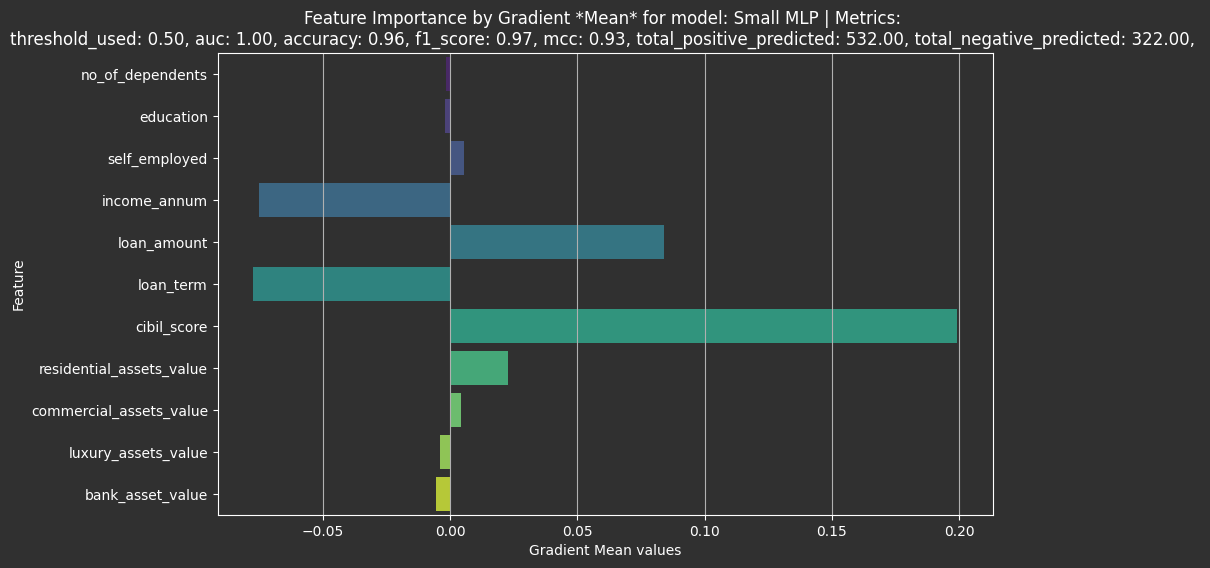

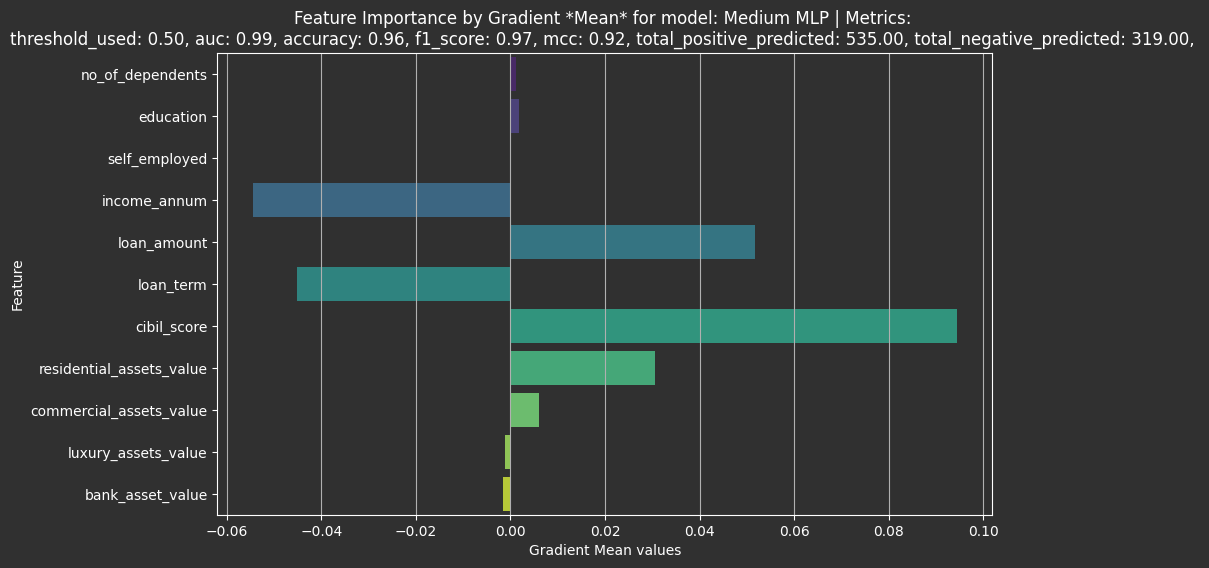

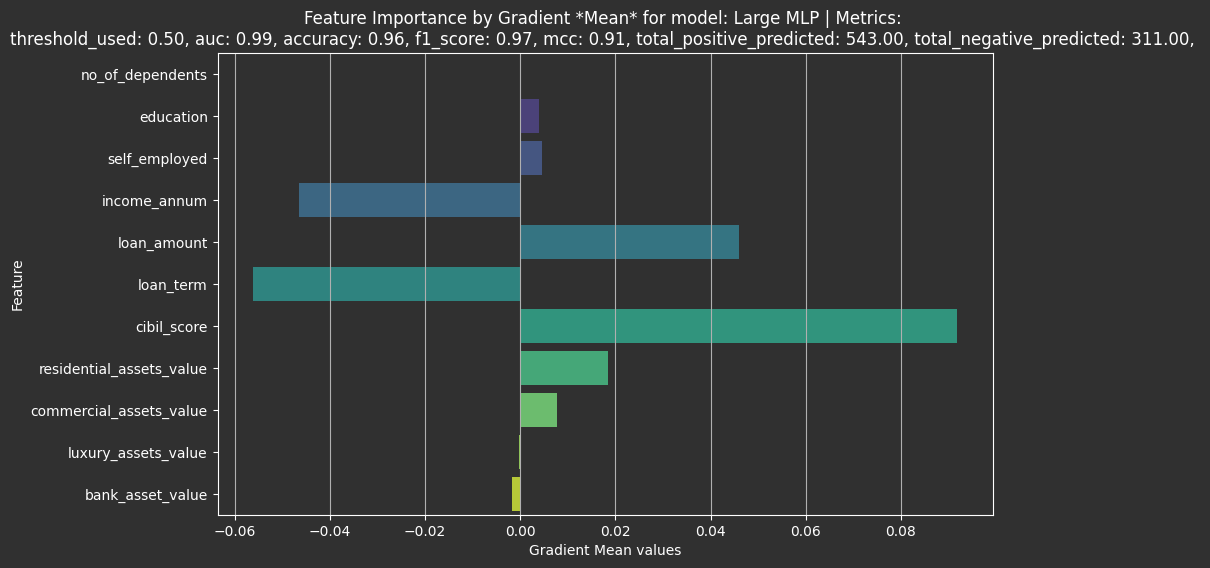

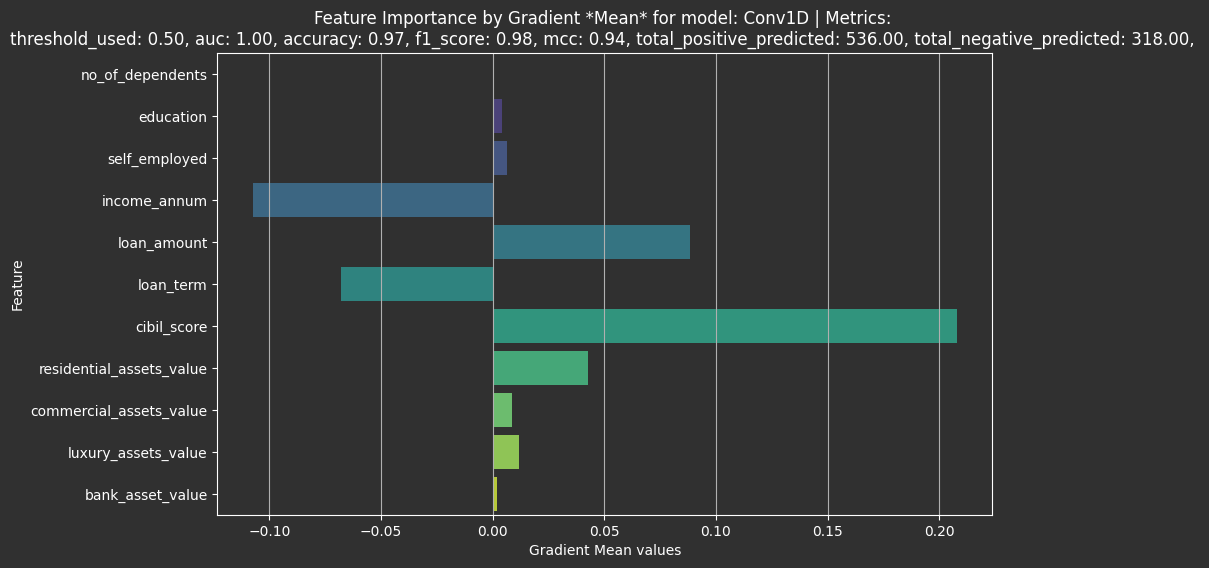

In [51]:
for model_result in torch_models_results:
    model_name = model_result["model_name"]
    model = model_result["model"]
    metrics = model_result["metrics"]
    mean_grads = calculate_and_plot_gradients(
        model, model_name, loan_ds, plot_first_num=0, metrics=metrics
    )

As expected, the cibil_score is significantly informative across all models,
confirming our idea that the average gradient represents the features importance to the model.

The average gradient of the score with respect to this feature is very high, indicating that increasing the cibil_score aligns with the direction of the gradient, which in turn enhances the score as we saw in the cibil_score plot.

Similarly, reducing the loan_term leads to a higher score in average, as the average gradient with respect to this feature is negative.

Additionally, as models increase in size, they begin to consider additional features. This is evident by the mean gradient vector becoming more uniform in terms of absolute values across different features. Suggesting that larger models utilize a broader range of features.

This expansion in feature usage by larger models can be explained by their improved ability to discern the relationships between less informative features and the loan_status compared to smaller models, thereby incorporating these lower-information features into their assessments.


## Strategic Users


Here we define the function that changes the features


In [52]:
def create_strategists_loan_ds(
    loan_ds_to_change: pd.DataFrame,
    range_strategists_act: Tuple[float, float],
    features_to_change: Dict[str, Tuple[Tuple[float, float], float]],
    model_to_fool: nn.Module,
    trainable_version=True,  # if false will have extra columns that not need for train,
    # but can make it trainable again with make_strategists_loan_ds_trainable() function
):
    """
    Calculates gradients for each row in the dataset, plots the gradient magnitudes
    for the first 'plot_first_num' rows, and finally plots the mean gradient magnitude.
    Args:
    - loan_ds_to_change: loan dataset to change
    - range_strategists_act: The score range of which users are chosen to be strategic. i.e. (0.3, threshold)
    - features_to_change: feature -> (range to sample the change, sign[add or sub]) :
        A dictionary of features to change, with a range to choose from and a sign
    - model_to_fool: The model to try and fool

    Returns:
    - strategists_loan_ds: loan dataset after performing strategies.
    - strategists_rows: The rows of users that performed strategy
    """
    strategists_loan_ds = loan_ds_to_change.copy()
    for index, row in strategists_loan_ds.iterrows():
        X = row.drop("loan_status").values
        X = scaler.transform(X.reshape(1, -1))
        X = torch.tensor(X, dtype=torch.float32).to(device)
        if trainable_version:
            y_pred = model_to_fool(X).item()
            # add the y_pred as score column
            strategists_loan_ds.at[index, "score_before_strategy"] = y_pred
        if range_strategists_act[0] <= y_pred and y_pred <= range_strategists_act[1]:
            # set the using_strategy column to True
            strategists_loan_ds.at[index, "using_strategy"] = 1
            for feature_name, feature_info in features_to_change.items():
                # feature_info is a tuple of (range, sign)
                feature_range_low = feature_info[0][0]
                feature_range_high = feature_info[0][1]
                feature_sign = feature_info[1]
                value_to_add = np.random.uniform(
                    feature_range_low, feature_range_high)
                strategists_loan_ds.at[index, feature_name] += float(
                    value_to_add * float(feature_sign)
                )
        else:
            strategists_loan_ds.at[index, "using_strategy"] = 0
    strategists_rows = strategists_loan_ds[strategists_loan_ds["using_strategy"] == 1]
    if trainable_version:
        # Drop the unwanted columns
        strategists_loan_ds.drop(
            ["using_strategy", "score_before_strategy"], axis=1, inplace=True
        )

    return strategists_loan_ds, strategists_rows


def make_strategists_loan_ds_trainable(strategists_loan_ds):
    """if instantiated with trainable_version=False, will have extra columns
    that not need for train, so use this function to make it trainable again."""
    strategists_loan_ds_trainable = strategists_loan_ds.copy()
    # remove the columns
    strategists_loan_ds_trainable.drop(
        ["using_strategy", "score_before_strategy"], axis=1, inplace=True
    )
    return strategists_loan_ds_trainable

## Simulation


### The General Idea

We'll utilize the above function to implement an initial dynamic simulation.

The simulation would have T timestamps, starting with the initial loan dataset (loan_ds).

At each timestamp, the process involves calculating the mean gradients of features, selecting the top K features with the highest absolute mean gradient (as these have the most significant impact on the model), and recording these in a 'features_to_change' list.

The selected features are then added (or substracted, depends on the gradient sign) for strategic users only with certain score range below the threshold; a value sampled uniformly within the range of:

[feature current mean * strategy magnitude, feature current mean * (strategy magnitude + 0.1)]


In [53]:
def run_first_simulation(
    T: int,
    K: int,
    MODEL: str,
    strategy_magnitude: float,
    range_strategists_act: Tuple[float, float],
    threshold=0.5,
    print_mean_grads_every=5,
):
    """
    Runs a simulation with T timestamps, K top features to change, and a strategy magnitude.

    Args:
    - T: The number of timestamps to run the simulation.
    - K: The number of top features to change.
    - MODEL: The model to use.
    - strategy_magnitude: The magnitude is a ratio of the mean feature value to change.
    - range_strategists_act: The score range of which users are chosen to be strategic. i.e. (0.3, threshold)
    """

    strategists_loan_ds_dict = {}
    strategists_rows_dict = {}
    results_dict = {}

    names_to_models = get_names_to_new_models(input_size)
    for model_name, _ in names_to_models.items():
        strategists_loan_ds_dict[model_name] = loan_ds.copy()

    for t in range(T):
        logging.info(f"Timestamp {t}:")
        for model_name, model in names_to_models.items():
            if model_name != MODEL:  # Get rid off this line to run on all models
                continue

            model = model.to(device)
            # Prepare the data
            X_torch_train_scaled, X_torch_test_scaled, train_loader, test_loader = (
                prepare_data(strategists_loan_ds_dict[model_name])
            )
            # Train and evaluate
            results_dict[model_name] = train_and_evaluate_pytorch_model(
                threshold, model, model_name, train_loader, test_loader
            )
            metrics = results_dict[model_name]["metrics"]
            logging.debug(metrics)
            # calculate and plot gradients

            mean_grads = calculate_and_plot_gradients(
                model,
                model_name,
                strategists_loan_ds_dict[model_name],
                plot_first_num=0,
                metrics=metrics,
                plot_mean=(t % print_mean_grads_every == 0),
            )

            # Get the top K features
            top_k_indices = np.argsort(np.abs(mean_grads))[::-1][:K]
            top_k_features = strategists_loan_ds_dict[model_name].columns[top_k_indices]
            logging.debug(
                f"Top {K} features for model {model_name}: {top_k_features}")

            # Create features_to_change dictionary
            features_to_change = {}
            for feature, index in zip(top_k_features, top_k_indices):
                # logging.info(
                #     f"Mean gradient for {feature}: {mean_grads[index]}")
                mean_feature_value = strategists_loan_ds_dict[model_name][
                    feature
                ].mean()
                # features_to_change is a dictionary of feature: (range, gradient)
                range_to_sample_change_from = (
                    # Here we need to change to be mul by features_strategy_magnitude[feature]
                    mean_feature_value * strategy_magnitude,
                    mean_feature_value
                    # here take like prev line + 0.1
                    * (strategy_magnitude + 0.1),
                )
                features_to_change[feature] = (
                    range_to_sample_change_from,
                    np.sign(mean_grads[index]),
                )

            logging.debug(
                f"Features to change for model {model_name}: {features_to_change}"
            )

            # Create strategists_loan_ds
            strategists_loan_ds_dict[model_name], strategists_rows_dict[model_name] = (
                create_strategists_loan_ds(
                    strategists_loan_ds_dict[model_name],
                    range_strategists_act,
                    features_to_change,
                    model,
                )
            )

            logging.debug(
                f"Model {model_name} created {len(strategists_rows_dict[model_name])} strategists."
            )

    # Show mean gradients for the models chosen
    for model_result in results_dict.values():
        if model_result["model_name"] != MODEL:
            continue
        model_name = model_result["model_name"]
        model = model_result["model"]
        metrics = model_result["metrics"]
        calculate_and_plot_gradients(
            model,
            model_name,
            strategists_loan_ds_dict[model_name],
            plot_first_num=0,
            metrics=metrics,
        )

For simulations, we are using Large MLP only, to reduce simulations time,
and as we already observed - different models behave pretty similar.


### Expectations

In this simulation we expect to observe several things when we change: strategy_magnitude, range_strategists_act.
This in fact, will be our simulation that proves/disproves hypotheses A + B.

When the strategy_magnitude is set to 0.6 and the range_strategists_act is within the range of 0.0 to a specified threshold, the model is likely to quickly converge to a performance that appears random. This is because strategies pile up in the features and the features become not informative.

Consequently, the mean gradients will undergo drastic changes and are likely to become more uniform compared to their initial state, as the features become less and less important.

Our observations indicate that a T value of 10 is sufficient.


### Experiment 1

INFO: Timestamp 0:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 28.03it/s]


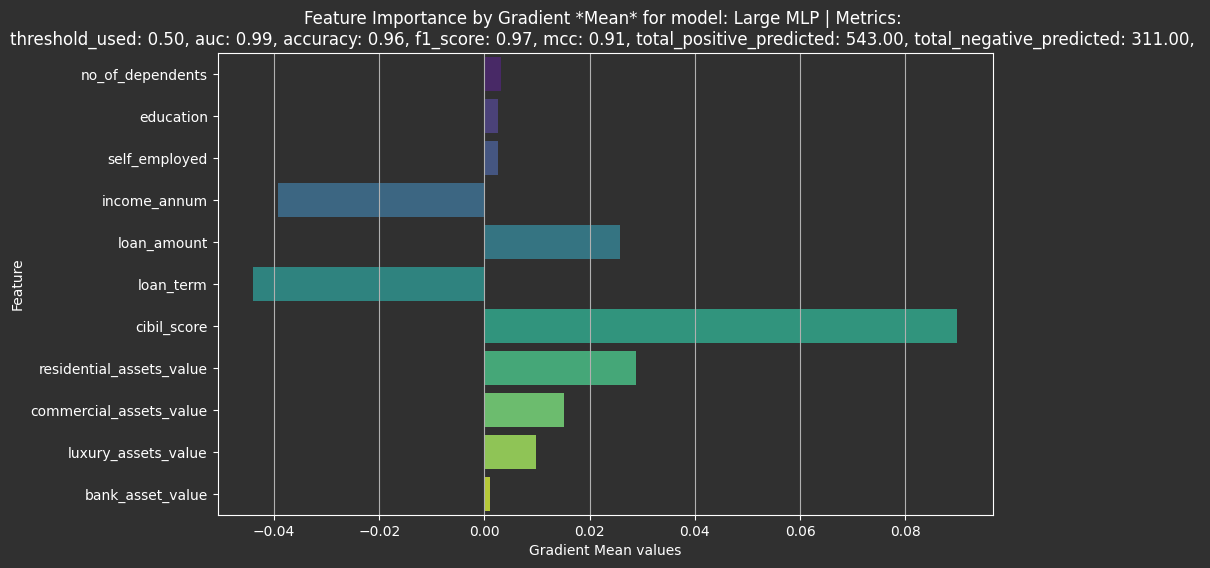

/var/folders/6q/cv5n11q16_g3rwq7b_g5fjnc0000gp/T/ipykernel_1073/2194740048.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '799.4316423275518' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, feature_name] += float(
INFO: Timestamp 1:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 28.84it/s]
INFO: Timestamp 2:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 28.71it/s]
INFO: Timestamp 3:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 29.09it/s]
/var/folders/6q/cv5n11q16_g3rwq7b_g5fjnc0000gp/T/ipykernel_1073/2194740048.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4972411.7913587475' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, feature_na

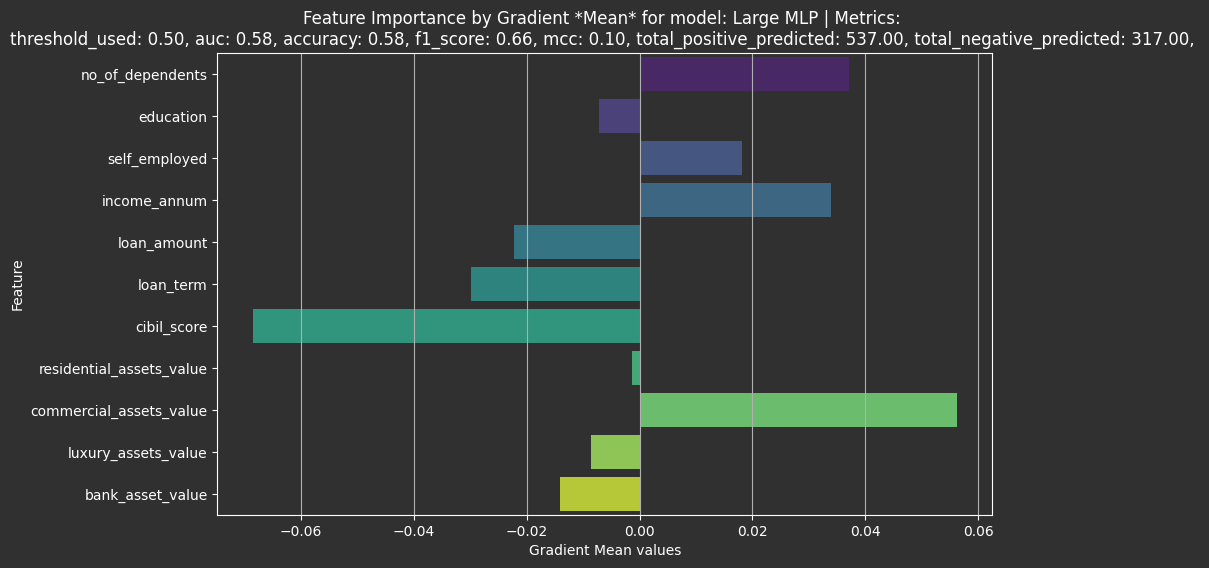

INFO: Timestamp 6:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 29.16it/s]
/var/folders/6q/cv5n11q16_g3rwq7b_g5fjnc0000gp/T/ipykernel_1073/2194740048.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '20903274.00977798' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, feature_name] += float(
INFO: Timestamp 7:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 29.35it/s]
/var/folders/6q/cv5n11q16_g3rwq7b_g5fjnc0000gp/T/ipykernel_1073/2194740048.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0195609904383431' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, feature_name] += float(
INFO: Timestamp 8:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:0

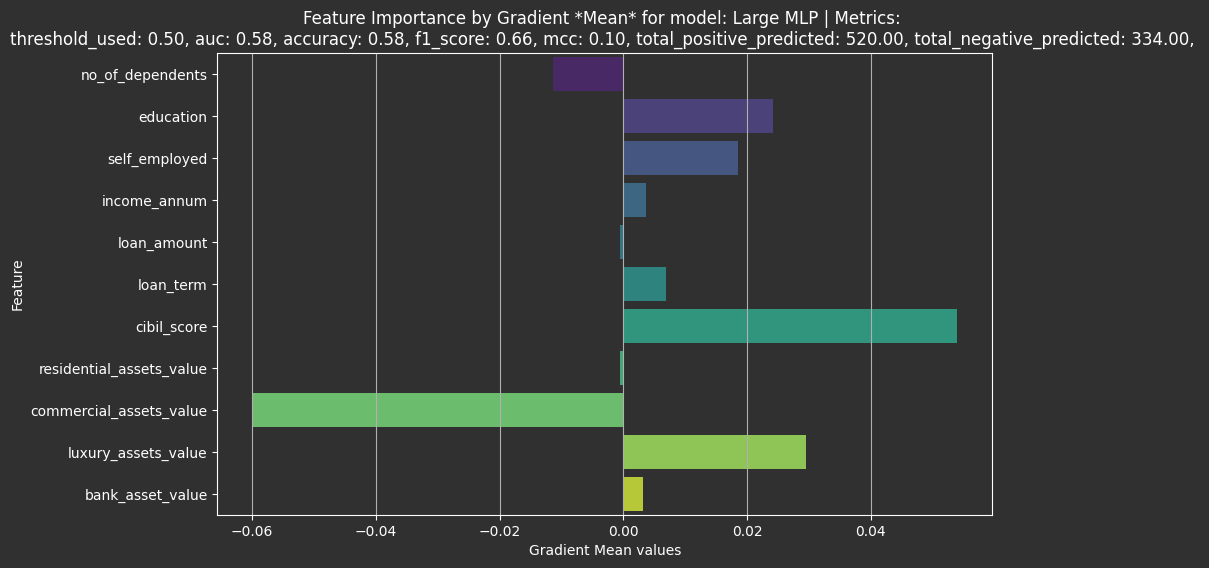

In [54]:
run_first_simulation(
    T=10,
    K=1,
    MODEL="Large MLP",
    strategy_magnitude=0.6,
    range_strategists_act=(0.0, threshold),
    print_mean_grads_every=5,
)

As we can see in the graphs above, the model started with reasonable gradients that put importance on cibil_score. After 5 epochs, the vector became pretty uniform and changed the most important feature. After another 5 epochs everything changed again,
which confirms our hypothesis that the gradient won't be informative anymore.

Hypothesis A confirmed! </br>
We can clearly see that the most important feature, cibil_score, had its importance decrease over time.

Hypothesis B confirmed! </br>
After 5 epochs we have 0.61 acc, and after 10 we have 0.56, which confirms our hypothesis that the model will become pretty random (almost 50% accuracy) for this setting (agressive strategy and strategists are all the users below the threshold, namely, with score within [0, threshold=0.5]).


### Experiment 2


In this experiment, we will define that strategists act if they get model score
in the range [0.2, 0.5].

Therefore, we expect that after some timestamps, the strategists that were initially in that range will get above the threshold and will be classified as ones that can take a loan. Moreover, we expect that those under 0.2 will probably never use strategy so the model will be correct on them.

INFO: Timestamp 0:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 28.72it/s]


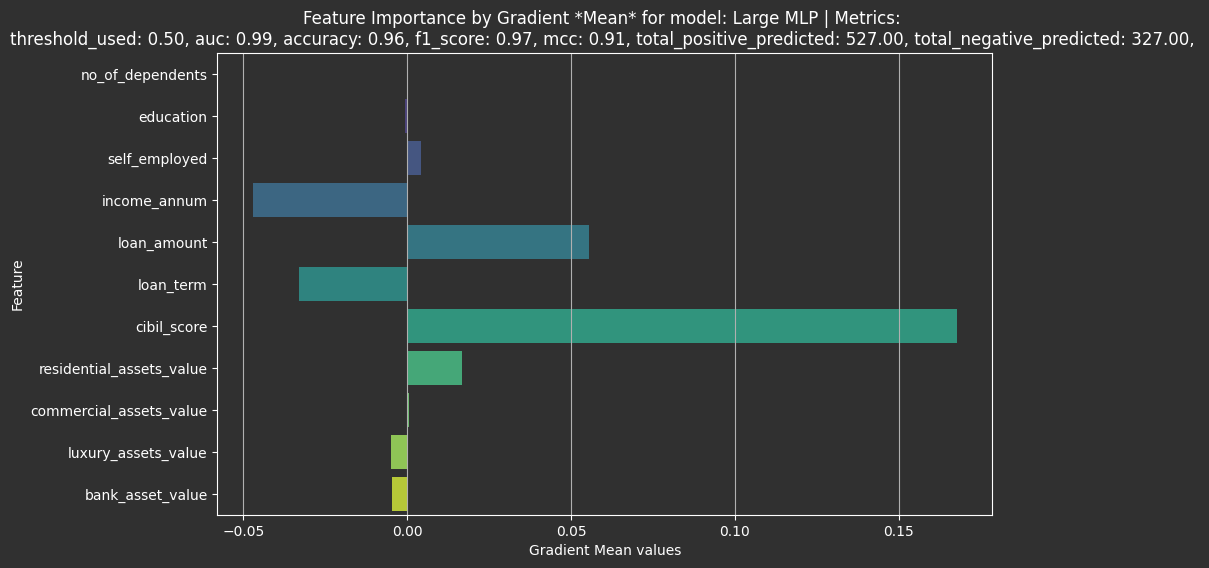

/var/folders/6q/cv5n11q16_g3rwq7b_g5fjnc0000gp/T/ipykernel_1073/2194740048.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1050.003360794909' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, feature_name] += float(
INFO: Timestamp 1:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 29.09it/s]
INFO: Timestamp 2:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 29.28it/s]
INFO: Timestamp 3:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 27.87it/s]
INFO: Timestamp 4:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]
INFO: Timestamp 5:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


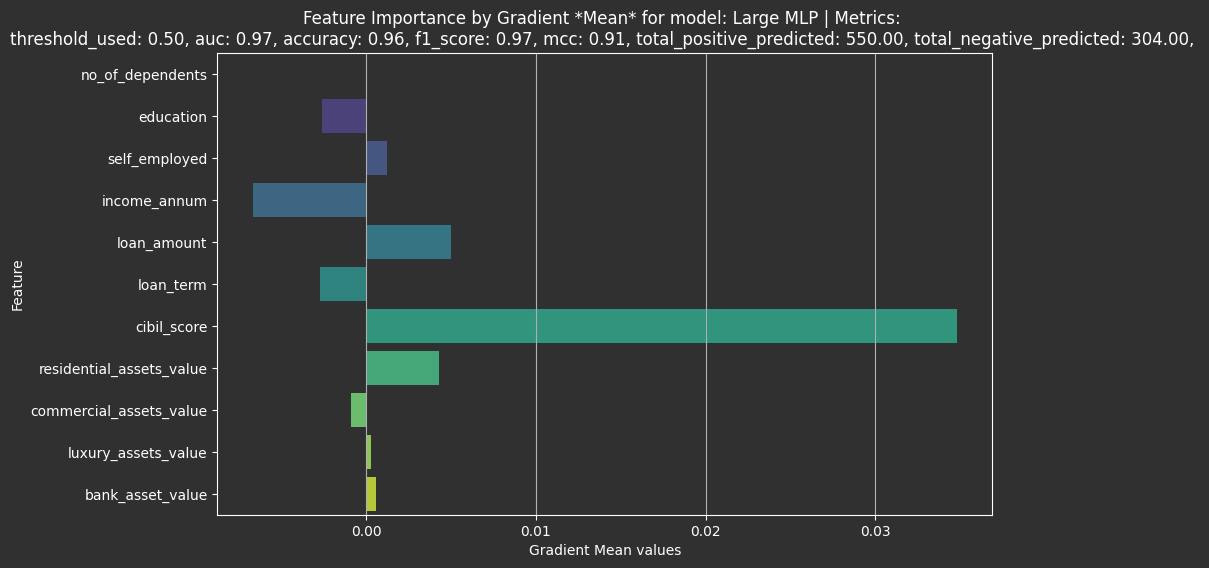

INFO: Timestamp 6:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 28.61it/s]
INFO: Timestamp 7:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 28.91it/s]
INFO: Timestamp 8:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 29.16it/s]
INFO: Timestamp 9:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 27.67it/s]


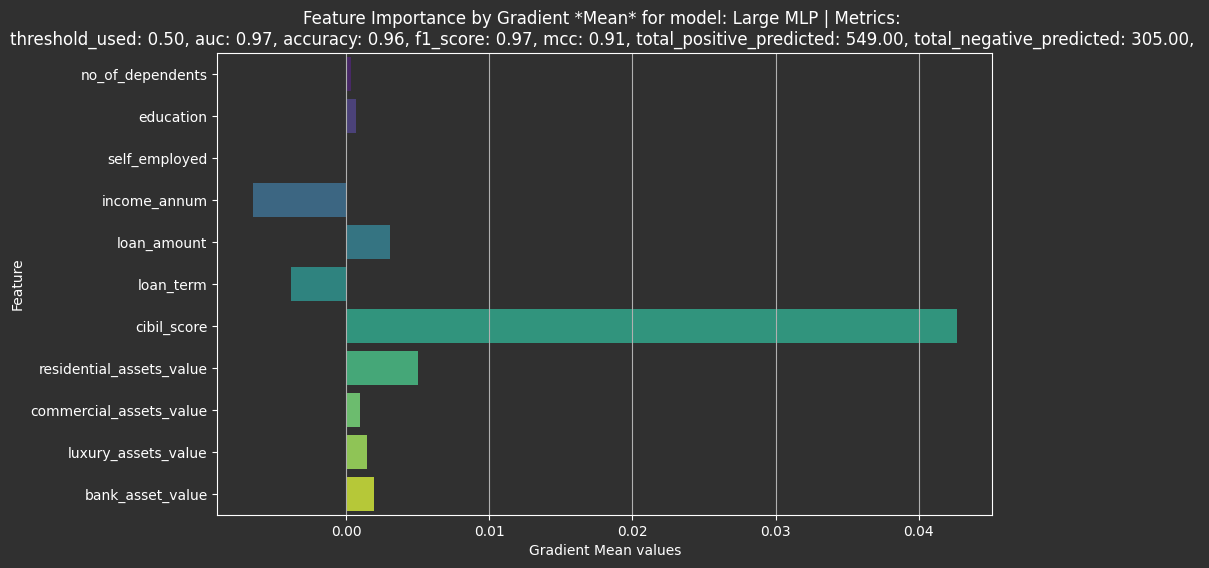

In [55]:
threshold = 0.5
run_first_simulation(
    T=10,
    K=1,
    MODEL="Large MLP",
    strategy_magnitude=0.9,
    range_strategists_act=(max(0, threshold - 0.3), threshold),
    print_mean_grads_every=5,
)

That's surprising. Even though we define strategists to act in [0.2, 0.5]
it seems the model performance remained pretty stable.

Apparently, we figured that this happened because most of the people that are below the threshold have a score less than 0.2. Therefore, there aren't a lot of strategists and asa result, the accuracy remains stable and the gradient vector shows good results (gives cibil_score the most importance).

### Experiment 3

Let's try again, but this time we'll define a new range of [0.01, 0.5] for strategists to act.

INFO: Timestamp 0:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 27.95it/s]


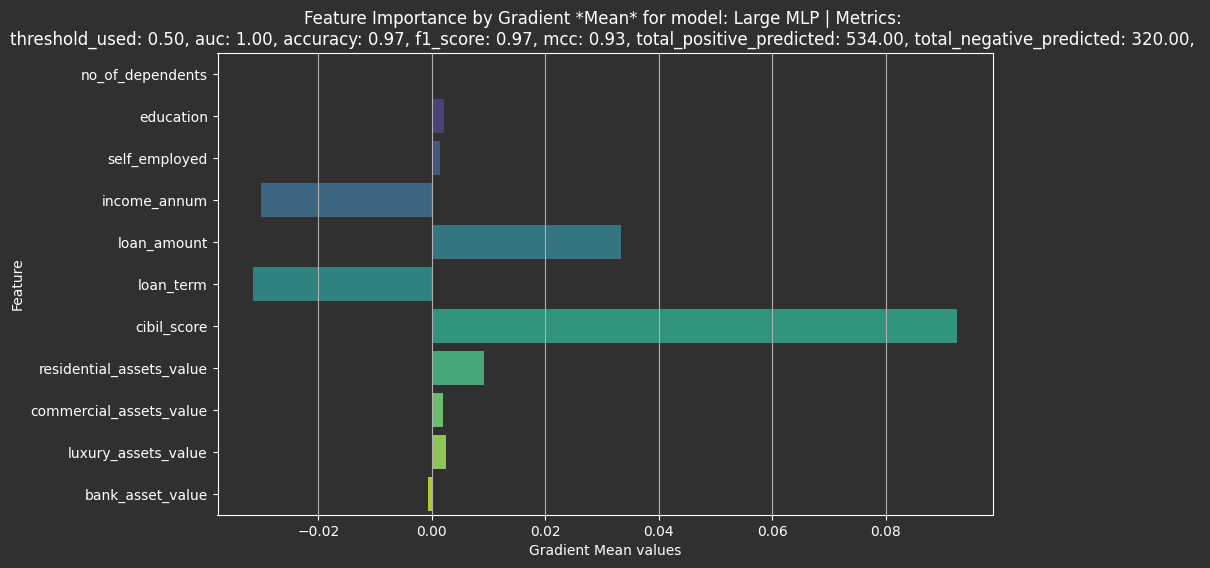

/var/folders/6q/cv5n11q16_g3rwq7b_g5fjnc0000gp/T/ipykernel_1073/2194740048.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1091.6516743099924' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, feature_name] += float(
INFO: Timestamp 1:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 27.66it/s]
INFO: Timestamp 2:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 28.57it/s]
INFO: Timestamp 3:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]
INFO: Timestamp 4:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]
INFO: Timestamp 5:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


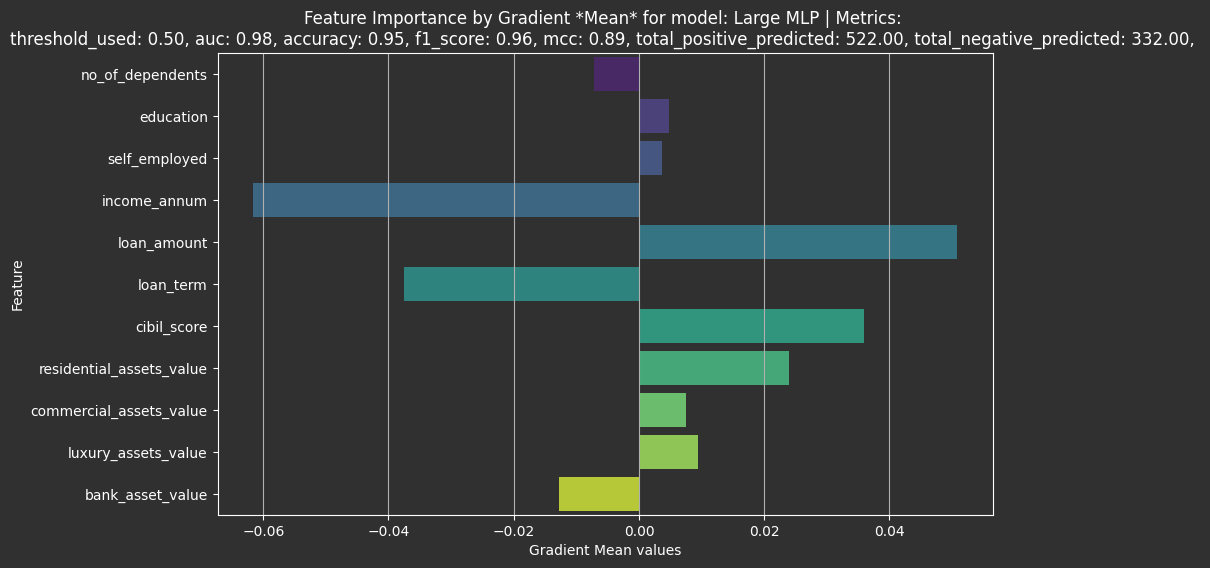

/var/folders/6q/cv5n11q16_g3rwq7b_g5fjnc0000gp/T/ipykernel_1073/2194740048.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '854998.0153100817' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, feature_name] += float(
INFO: Timestamp 6:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]
INFO: Timestamp 7:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 29.22it/s]
INFO: Timestamp 8:
Training Large MLP: 100%|██████████| 100/100 [00:03<00:00, 28.78it/s]
/var/folders/6q/cv5n11q16_g3rwq7b_g5fjnc0000gp/T/ipykernel_1073/2194740048.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-4.819987708368783' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, feature_na

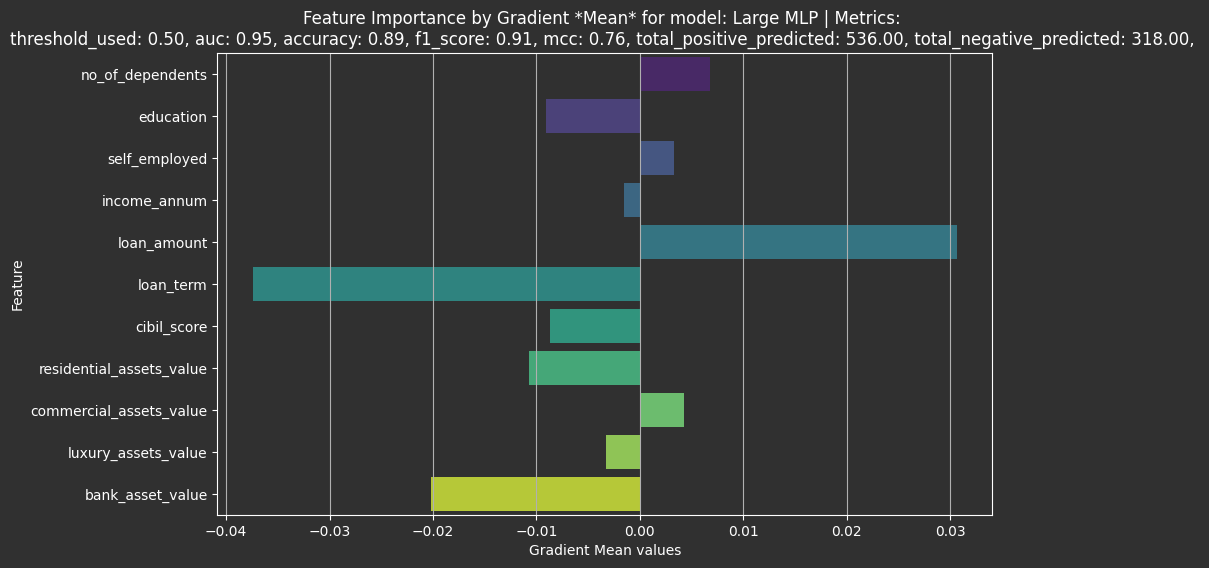

In [56]:
threshold = 0.5
run_first_simulation(
    T=10,
    K=1,
    MODEL="Large MLP",
    strategy_magnitude=0.9,
    range_strategists_act=(max(0, threshold - 0.49), threshold),
    print_mean_grads_every=5,
)

Now we got the results we were expecting for.
We can see the model's accuracy being harmed but not drastically (~0.85). The reason behind that is that all people with score < 0.01 remained untouched and therefore the model is correct about them.

That aligns with our C Hypothesis!

### Conclusions

We thought that this simulation resemebled real life. How?

Imagine a bank that wants to give loans to "good loaners". People that are close to get a loan, would each time change the feature that is the most important for the bank.
In our case - this feature is the feature with the highest absolute gradient when calculated with the bank's model.

The resemblance is noticed by thinking that people talk with each other and bank advisors, know what's the most important feature for the bank and change their feature accordingly. Just as we did in this simulation.

So we can conclude that in this dynamic system, people near the threshold will eventually succeed to get the loan if they "satisfy" the bank with the important feature and accumulate those changes over time. But, those who are not using strategy all the time will remain below the threshold and the model will keep classifying them correctly and thus, the model's accuracy will be just partially harmed.

We can conclude that in such a dynamic system, even most informative features such as cibil score, have their importance deteriorate over time. People notice they need a high cibil score, for example, to get a loan, and therefore change it strategically.

# Section 3: Simulation with Weights


## Intro


In this section, we'll adopt a more realistic approach. In contrary to the previous part, we'll not choose strategic features according to their mean gradient.
We'll choose features according to what realistically can be modified and to what extent.

In our simulation the assumption is that the bankers evaluate how much people can change each feature. Their assumption is a scalar, that is used to sample the change in features that the strategy can cause. They don't know how the strategic users sample the change, they only know the "reliability" of each feature as a scalar. 
We also assume that they're right in their assumption.

Therefore, for each feature, we'll attach a reliability score in the range of [0,1] (note that the strategic magnitude is 1-reliability), which would then be used to calculate how much the user can add or subtract to the feature. We would call the feature->reliability mapping the "Feature Strategy Vector".

To the reliability we'll also attach a sign 1 or -1 to indicate if the strategic users(in some certain score range) will add to the value or reduce from it. We will choose the numbers 1 or -1 according to the gradient vectors calculated at the beginning.
For example, we will give cibil_score a "+1" sign because the gradient was positive and -1 to income_annum cause it was negative which means that people might want to reduce it (assuming the problem is pretty linear). </br>
Namely, people know that bank values cibil score so they want to magnify this feature and thus, the reliability of this feature for the bank would be low.

In each simulation experiment we will train 2 models, initial+baseline for the first set of experiments, and baseline+informed for the second set.

1. Initial model (model_for_initial_scores) - A model that is regulary trained. According to the scores it gives to users, we choose the strategists, by choosing those who got a score between 0.05 and 0.5 for example.

2. Informed model - A model that utilizes the feature strategy vector to perform better. That's the bank that evaluates the reliability of features to improve the model. There are a lot of ideas how to utilize the features' reliabilities; we will present some and implement some.

3. Baseline model - A model that trains on the dataset after the strategists act and tested on the strategic dataset or on the clean dataset. Note that we can compare its performance to the initial model to see how much the strategists harmed the data and to the informed model.

Our goal is to help the bank utilize the reliability to enhance the informed model when comparing to the same model that did not utilize this information (baseline model).

## Cibil Score

In this section, we would show a rather anticipated result that would help us in the subsequent sections.

Training Large MLP: 100%|██████████| 100/100 [00:04<00:00, 24.50it/s]


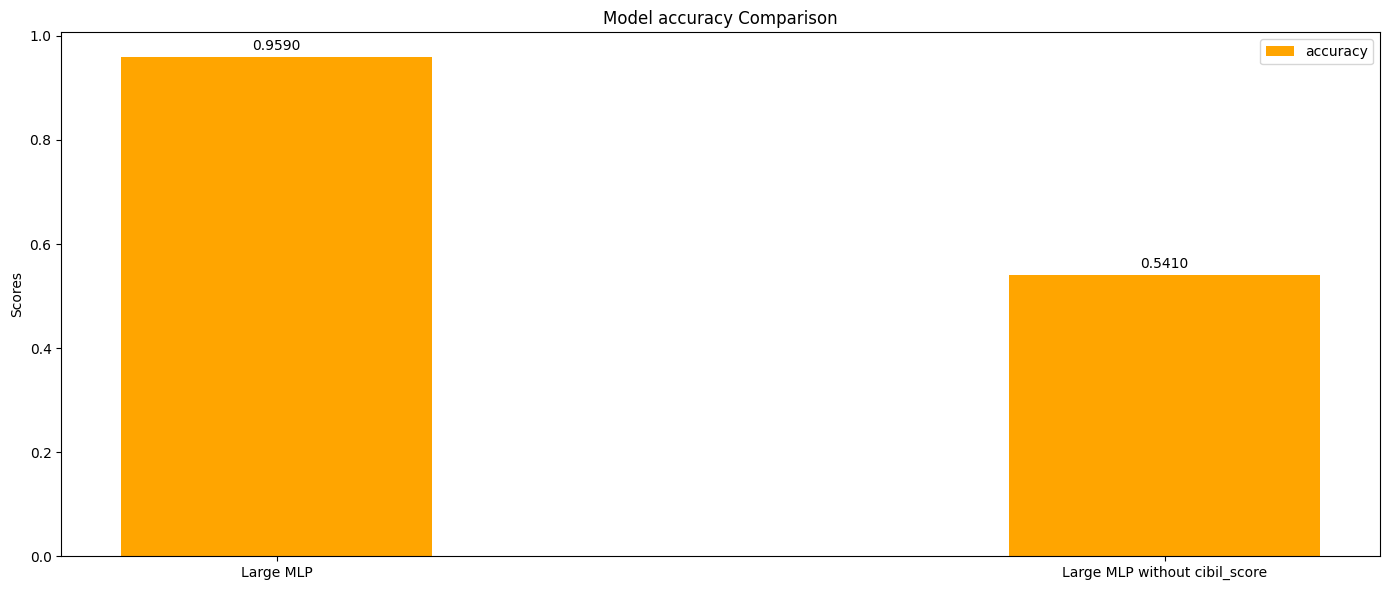

In [62]:
def copy_without_cols(df, cols):
    """Return a copy of the DataFrame without the specified columns."""
    copy = df.copy()
    return copy.drop(cols, axis=1)

# Copy the dataset without cibil_score
partial_loan_ds = copy_without_cols(loan_ds, ["cibil_score"])
X_torch_train_scaled, X_torch_test_scaled, train_loader, test_loader = prepare_data(
    partial_loan_ds
)

input_size = X_torch_train_scaled.shape[1]
names_to_models = get_names_to_new_models(input_size)
threshold = 0.5

# Take the result of Large MLP when the data was full
torch_models_results_2 = [result for result in torch_models_results if result["model_name"] == "Large MLP"]

for model_name, model in names_to_models.items():
    if model_name != "Large MLP":
        continue
    model = model.to(device)
    result = train_and_evaluate_pytorch_model(
        threshold, model, model_name, train_loader, test_loader
    )
    result["model_name"] = "Large MLP without cibil_score"
    torch_models_results_2.append(result)
    
compare_torch_models(torch_models_results_2, ["accuracy"])

From the above result, we see that the model highly depended on cibil_score.
In the subsequent sections, we'll tackle this issue by creating a dataset with more "informative" features to make our simulations more interesting.

## Helper Functions and Classes

In [28]:
from enum import Enum


def get_ds_features_names(ds):
    """Return all cols names except for loan_status if exists"""
    return ds.columns.drop("loan_status").tolist()


def get_large_mlp_model(input_size):
    return get_names_to_new_models(input_size)["Large MLP"].to(device)


def create_features_to_change_from_strategy_vector(
    ds: pd.DataFrame, feature_strategy_vector: Dict[str, Dict[str, float]]
) -> Dict[str, Tuple[Tuple[float, float], float]]:
    """
    Creates a dictionary of features to change from the feature_strategy_vector.

    Args:
    - ds: The loan dataset.
    - feature_strategy_vector: The feature strategy vector.

    Returns:
    - features_to_change: A dictionary of features to change.
    """
    features_to_change = {}
    for feature, reliability_info in feature_strategy_vector.items():
        strategy_magnitude = reliability_info["strategy_magnitude"]
        sign = reliability_info["sign"]
        mean_feature_value = ds[feature].mean()
        range_to_sample_change_from = (
            mean_feature_value * strategy_magnitude,
            mean_feature_value * (strategy_magnitude + 0.1),
        )
        features_to_change[feature] = (
            range_to_sample_change_from,
            sign,
        )
        # logging.info(
        #     f"Feature {feature} has strategy_magnitude: {strategy_magnitude} and sign: {sign}"
        # )
    return features_to_change


def ds_copy_with_chosen_features(ds, features_cols):
    """
    Returns a copy of the dataset with only the chosen features and loan_status columns.
    """
    return ds[features_cols + ["loan_status"]].copy()


def train_on_chosen_features(
    ds, model, features_cols, threshold=0.5, model_name="model"
):
    ds_with_chosen_features = ds_copy_with_chosen_features(ds, features_cols)
    _, _, train_loader, test_loader = prepare_data(ds_with_chosen_features)
    model_results = train_and_evaluate_pytorch_model(
        threshold, model, model_name, train_loader, test_loader
    )
    return model_results


class InformedAlgoArgs:
    def __init__(self):
        pass


class DropKMostStrategicFeaturesAlgoArgs(InformedAlgoArgs):
    def __init__(self, k: int):
        self.k = k


class ModelsAggregationAlgoArgs(InformedAlgoArgs):
    def __init__(self, k: int):
        self.k = k

## Simulation

In [29]:
def strategy_vector_simulation(
    clean_ds,
    feature_strategy_vector,
    range_strategists_act,
    compare_baseline_and_initial_only=False,
    threshold=0.5,
    informed_algo_args=None,
):
    # for each dict in feature_strategy_vector, add strategy_magnitude to be 1 - reliability
    for feature, reliability_info in feature_strategy_vector.items():
        feature_strategy_vector[feature]["strategy_magnitude"] = (
            1 - reliability_info["reliability"]
        )
        # assert that reliability and strategy_magnitude are in the correct range
        assert 0 <= reliability_info["reliability"] <= 1
        assert 0 <= feature_strategy_vector[feature]["strategy_magnitude"] <= 1

    logging.debug(f"feature_strategy_vector: {feature_strategy_vector}")

    # First, make initial model that will score the users, so we can define the strategists
    # that act within a certain range of scores:
    model_for_initial_scores = get_large_mlp_model(input_size)
    # Then - we will make strategists ds, and train 2 models,
    # baseline model that not use the feafeature_strategy_vector:
    baseline_model = get_large_mlp_model(input_size)

    # train the model_for_initial_scores:
    _, _, clean_ds_train_loader, clean_ds_test_loader = prepare_data(clean_ds)
    initial_model_results = train_and_evaluate_pytorch_model(
        threshold,
        model_for_initial_scores,
        "model_for_initial_scores",
        clean_ds_train_loader,
        clean_ds_test_loader,
    )
    initial_model_metrics = initial_model_results["metrics"]

    logging.debug(
        f"Initial model metrics: {metrics_to_tabular_string(initial_model_metrics)}"
    )

    features_to_change = create_features_to_change_from_strategy_vector(
        clean_ds, feature_strategy_vector
    )
    logging.debug(f"features_to_change: {features_to_change}")

    # create strategic_ds using model_for_initial_scores:
    strategists_ds, strategists_rows = create_strategists_loan_ds(
        clean_ds,
        range_strategists_act,
        features_to_change,
        model_for_initial_scores,
        trainable_version=True,
    )
    logging.debug(
        f"There are {len(strategists_rows)} strategists from {len(clean_ds)} users."
    )

    # train the baseline model without looking at the feature_strategy_vector:
    _, _, strategic_train_loader, strategic_test_loader = prepare_data(strategists_ds)
    if compare_baseline_and_initial_only:
        baseline_train_loader = strategic_train_loader
    else:
        # we want to compare to informed model, so both train on clean ds and tested on strategic ds
        baseline_train_loader = clean_ds_train_loader
    baseline_test_loader = strategic_test_loader
    baseline_model_results = train_and_evaluate_pytorch_model(
        threshold,
        baseline_model,
        "baseline_model",
        baseline_train_loader,
        baseline_test_loader,
    )
    baseline_model_metrics = baseline_model_results["metrics"]

    logging.debug(
        f"Baseline model metrics: {metrics_to_tabular_string(baseline_model_metrics)}"
    )
    if compare_baseline_and_initial_only:
        # plot acc of baseline and acc of initial model
        compare_torch_models(
            [initial_model_results, baseline_model_results],
            ["accuracy"],
        )
        return strategists_ds

    # train using algos the informed model, and then compare all 3 models.
    informed_model = None

    if informed_algo_args is None:
        logging.error(
            "informed_algo_args is None, so we will not train the informed model."
        )
        raise Exception(
            "informed_algo_args is None and compare_baseline_and_initial_only is False"
        )

    if isinstance(informed_algo_args, DropKMostStrategicFeaturesAlgoArgs):
        # drop the K most strategic features and train model
        k = informed_algo_args.k
        print(f"Using Drop K={k} Most Strategic Features Algo...")
        all_features_names = get_ds_features_names(strategists_ds)
        features_to_drop = sorted(
            feature_strategy_vector,
            key=lambda x: feature_strategy_vector[x]["reliability"],
        )[:k]
        print(f"Features to drop: {features_to_drop}")
        features_to_keep = list(set(all_features_names) - set(features_to_drop))
        print(f"Features to keep: {features_to_keep}")

        informed_model = get_large_mlp_model(len(features_to_keep))
        # train the informed model using the features_to_keep:
        strategic_ds_with_chosen_features = ds_copy_with_chosen_features(
            strategists_ds, features_to_keep
        )
        # informed model is tested on the test set with the chosen features
        _, _, _, informed_test_loader = prepare_data(strategic_ds_with_chosen_features)
        # informed model train on the clean data before strategists act, as in real life
        clean_ds_with_chosen_features = ds_copy_with_chosen_features(
            clean_ds, features_to_keep
        )
        _, _, informed_train_loader, _ = prepare_data(clean_ds_with_chosen_features)

        informed_model_results = train_and_evaluate_pytorch_model(
            threshold,
            informed_model,
            "informed_model",
            informed_train_loader,
            informed_test_loader,
        )

    elif isinstance(informed_algo_args, ModelsAggregationAlgoArgs):
        k = informed_algo_args.k
        print(f"Using Models Aggregation Algo with K={k}...")
        all_features_names = get_ds_features_names(strategists_ds)
        top_k_non_reliable_features = sorted(
            feature_strategy_vector,
            key=lambda x: feature_strategy_vector[x]["reliability"],
        )[:k]
        print(f"Top K non-reliable features: {top_k_non_reliable_features}")
        models_to_aggregate = []
        # will hold feature removed -> acc
        feature_removed_to_results = {}
        for i in range(k):
            # remove the ith most non-reliable feature:
            features_to_keep = list(
                set(all_features_names) - set([top_k_non_reliable_features[i]])
            )
            print(
                f"Train model {i+1} without the {i+1}th most non-reliable feature: {top_k_non_reliable_features[i]}"
            )
            model = get_large_mlp_model(len(features_to_keep))
            # train the model using the features_to_keep:
            strategic_ds_with_chosen_features = ds_copy_with_chosen_features(
                strategists_ds, features_to_keep
            )
            # model is tested on the strategic test set with the chosen features
            _, _, _, model_test_loader = prepare_data(strategic_ds_with_chosen_features)
            # model train on the clean data before strategists act, as in real life
            clean_ds_with_chosen_features = ds_copy_with_chosen_features(
                clean_ds, features_to_keep
            )
            _, _, model_train_loader, _ = prepare_data(clean_ds_with_chosen_features)

            model_results = train_and_evaluate_pytorch_model(
                threshold,
                model,
                f"model{i+1}_trained_without_{top_k_non_reliable_features[i]}",
                model_train_loader,
                model_test_loader,
                return_logits=True,
            )
            feature_removed_to_results[top_k_non_reliable_features[i]] = model_results
            models_to_aggregate.append(
                {
                    "model": model,
                    "logits": model_results["logits"],
                    "all_labels": model_results["all_labels"],
                    "feature_removed": top_k_non_reliable_features[i],
                }
            )
        informed_model_results = {"model_name": "aggregated_model"}
        all_labels = models_to_aggregate[0]["all_labels"]
        aggregator_logits = np.zeros_like(all_labels)
        # iterate models to aggregate and calculate the weighted sum
        for i, model_dict in enumerate(models_to_aggregate):
            model_logits = model_dict["logits"]
            feature_removed = model_dict["feature_removed"]
            # feature_strategic_magnitude is the model weight, because as
            # the feature dropped is more strategic - we want higher weight to
            # the model that dropped it.
            feature_strategic_magnitude = feature_strategy_vector[feature_removed][
                "strategy_magnitude"
            ]
            aggregator_logits += model_logits * feature_strategic_magnitude
        # normalize the logits
        aggregator_logits /= sum(
            feature_strategy_vector[feature_removed]["strategy_magnitude"]
            for feature_removed in top_k_non_reliable_features
        )

        informed_model_results["logits"] = aggregator_logits
        # calculate the metrics
        informed_model_results["metrics"] = calculate_metrics(
            all_labels, aggregator_logits, threshold
        )

    # compare baseline and informed. the initial not relevant cause tested on clean ds.
    # print(f"informed results: {informed_model_results}")
    compare_torch_models(
        [baseline_model_results, informed_model_results],
        ["accuracy"],
    )

### The General Idea

In the sub-section "Cibil Score", we checked what happens when we train the model on the dataset but without cibil_score. We got 0.58 accuracy without, and 0.96 with cibil_score.
So right now - most of the information is in cibil_score, but we will make the other features more informative later.

To choose a smart strategy, we look at the gradients in the begining of the notebook,
if we see high positive gradient - we put it here with +1 sign so it would be useful to deceive the model, if negative and with very low gradient we will put it with -1 sign.

In the following experiments, we track the changes in the accuracy of the baseline model to see which strategies harm or do not harm the model when it eventually knows the true labels. This might happen in the real world, because even if people use strategy the bank will know after some years if it has been deceived in case the user fails to return the loan. Therefore it would be logical for the bank to have the noised features with the correct labels. And that's why the baseline model is trained and tested on the strategists dataset.

After we make the dataset more informative (by giving importance to other features than cibil_score), we will examine a different situation, baseline and informed models need to operate in the real world in real time, where they are initially trained on a "clean" data but tested on an environment with strategic users.

### Experiment 1 - The Flipped Classifier

In the following experiment, we would show what happens if cibil_score is considered highly unreliable. In the terms defined above, this would mean that strategic users will perform strategy with high magnitude (magnitude = 1 - reliability).

In [30]:
feature_strategy_vector = {
    "cibil_score": {"reliability": 0.005, "sign": 1},
}
threshold = 0.5
range_strategists_act = (0.0, threshold)

strategists_ds = strategy_vector_simulation(
    loan_ds,
    feature_strategy_vector,
    range_strategists_act,
    compare_baseline_and_initial_only=True,
    threshold=threshold,
)

Training model_for_initial_scores:   0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x11 and 10x128)

We can see that the strategists merely harmed the model, now we will explain why.
Let's see the original ds before strategists act, look at the cibil_score:

In [ ]:
loan_ds.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0


And the strategists cibil_score:


In [ ]:
strategists_ds.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,778.000000,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,1039.918413,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,1114.457662,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,1118.196107,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,990.821355,12400000,8200000,29400000,5000000,0


We can see that the first user with 778 cibil score didn't change, and the others that wwere <= 506 got a huge boost (because we chose really low reliability so strategists make aggressive strategies). A logical explanation for this is that the model "flipped" its threshold and moved it a little bit so that users with relatively high cibil_score will not get a loan, as it's suspiciously high.

### Experiment 2 - Strategists are Harmful

In the following experiment, we would show what happens if cibil_score is considered somehwat unreliable.

Training model_for_initial_scores: 100%|██████████| 100/100 [00:03<00:00, 28.43it/s]
/var/folders/6q/cv5n11q16_g3rwq7b_g5fjnc0000gp/T/ipykernel_75859/2194740048.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '953.6934564031287' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, feature_name] += float(
Training baseline_model: 100%|██████████| 100/100 [00:03<00:00, 30.04it/s]


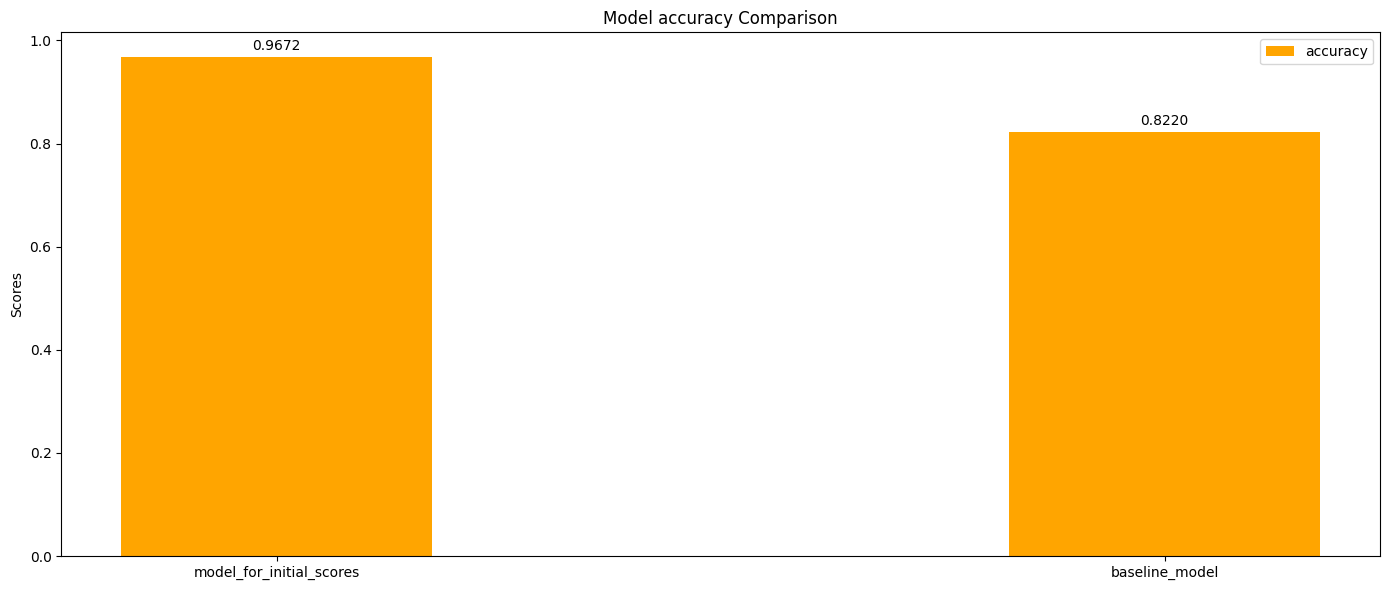

In [ ]:
feature_strategy_vector = {
    "cibil_score": {"reliability": 0.2, "sign": 1},
}
strategists_ds = strategy_vector_simulation(
    loan_ds,
    feature_strategy_vector,
    range_strategists_act,
    compare_baseline_and_initial_only=True,
    threshold=threshold,
)

Let's look again on the datasets:


In [ ]:
loan_ds.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0


In [ ]:
strategists_ds.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,778.000000,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,953.693456,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,999.011190,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,962.351695,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,868.001523,12400000,8200000,29400000,5000000,0


As we can see, the baseline model that trained on the dataset after strategists act - got ~0.79 accuracy, and the first model got ~0.95 accuracy.

The reason is, as we see in the heads of the dataset, choosing reliability = 0.2 to cibil_score caused the people who did not get a loan to have cibil_score that is not too much high (as the strategists failed in previous experiment), but exactly enter the area of the non-strategists that got a loan, so they deceived the model and therefore the accuracy noticeably decreased.

### Experiment 3 - Strategy on "Non-Important" Features


Recall Hypothesis D: If users will also use strategies in the "non-important" features - the model can overcome the strategies in the important features by identifying the strategists that change the non-important features and lower their scores.

As in the previous experiment we would define cibil_score's reliability = 0.2.

In the previous experiment it harmed the model a lot (0.79 acc), but now we will also put reliability (meaning strategists) on non-important features. We will see if the model can now improve by identifying them.

Training model_for_initial_scores: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]
/var/folders/6q/cv5n11q16_g3rwq7b_g5fjnc0000gp/T/ipykernel_75859/2194740048.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '949.315655651368' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, feature_name] += float(
/var/folders/6q/cv5n11q16_g3rwq7b_g5fjnc0000gp/T/ipykernel_75859/2194740048.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '20386434.392448604' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategists_loan_ds.at[index, feature_name] += float(
/var/folders/6q/cv5n11q16_g3rwq7b_g5fjnc0000gp/T/ipykernel_75859/2194740048.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an

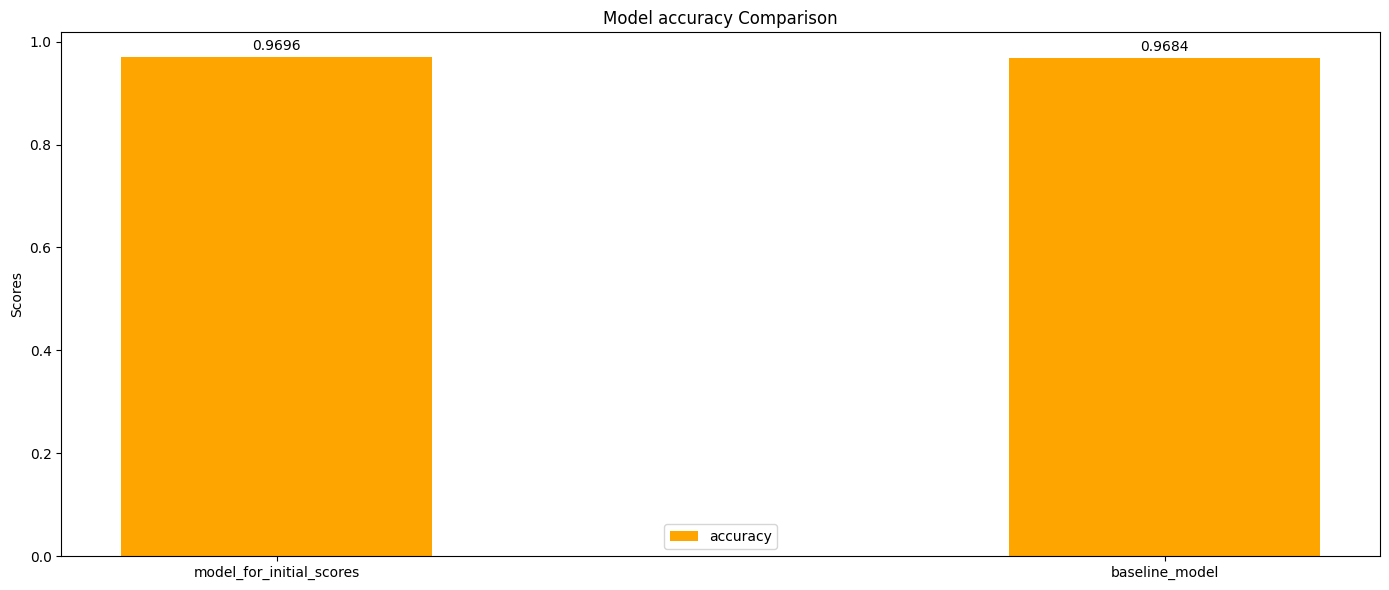

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9.600000e+06,2.990000e+07,12.000000,778.000000,2.400000e+06,17600000,22700000,8000000,1
1,0,0,1,4.728509e+05,2.038643e+07,-1.545086,949.315656,8.552919e+06,2200000,8800000,3300000,0
2,3,1,0,5.123160e+06,3.818507e+07,11.262841,1038.778156,1.241096e+07,4500000,33300000,12800000,0
3,3,1,0,4.623411e+06,3.934514e+07,-1.261415,952.502812,2.378407e+07,3300000,23300000,7900000,0
4,5,0,1,6.172389e+06,3.308395e+07,10.895444,880.589065,1.820934e+07,8200000,29400000,5000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4264,5,1,1,-2.979292e+06,9.938600e+06,3.094560,817.391023,8.726340e+06,500000,3300000,800000,0
4265,0,0,1,3.300000e+06,1.130000e+07,20.000000,559.000000,4.200000e+06,2900000,11000000,1900000,1
4266,2,0,0,2.583348e+06,3.198185e+07,8.323850,965.661503,6.707852e+06,12400000,18100000,7300000,0
4267,1,0,0,4.100000e+06,1.280000e+07,8.000000,780.000000,8.200000e+06,700000,14100000,5800000,1


In [ ]:
feature_strategy_vector = {
    "cibil_score": {"reliability": 0.2, "sign": 1},
    "loan_amount": {"reliability": 0.5, "sign": 1},
    "income_annum": {"reliability": 0.3, "sign": -1},
    "loan_term": {"reliability": 0.2, "sign": -1},
    "residential_assets_value": {"reliability": 0.3, "sign": 1},
}
strategy_vector_simulation(
    loan_ds,
    feature_strategy_vector,
    range_strategists_act,
    compare_baseline_and_initial_only=True,
    threshold=threshold,
)

As we can see, we imporved the model from 0.79 acc to 0.95 accuracy only by adding strategists!

Conclusion: banks can detect strategic users, even in features that the bank's model didn't use (For example: how many saving funds the user created last year, because maybe it's not important to indicate if user can return the loan, but can indicate if it's a strategic user), to improve the performance.

If there was no strategy in the non-important features, the model's accuracy would be ~0.79 as we saw in the last section. But as we saw it took into consideration the non-important features and improved by identifying the strategists, which confirms our D Hypothesis!


### Improve the Dataset


For for the future experiments to make more sense and in order to be able to implement meaningful algorithms and test them, we must have at least 2 informative features.

Right now there is only 1 informative feature, cibil_score,
which is actually too much informative so we will fix that too.

Let's change loan_ds a bit so that we would have more informative features,
we will make the following features informative in about the same magnitude:
- "loan_amount"
- "income_annum"
- "luxury_assets_value"
- "cibil_score" (was informative, we will make it as informative as the others, meaning, same accuracy if the model trained on each feature seperately)

In [ ]:
informative_loan_ds = loan_ds.copy()
informative_features = [
    "loan_amount",
    "income_annum",
    "luxury_assets_value",
    "cibil_score",
]

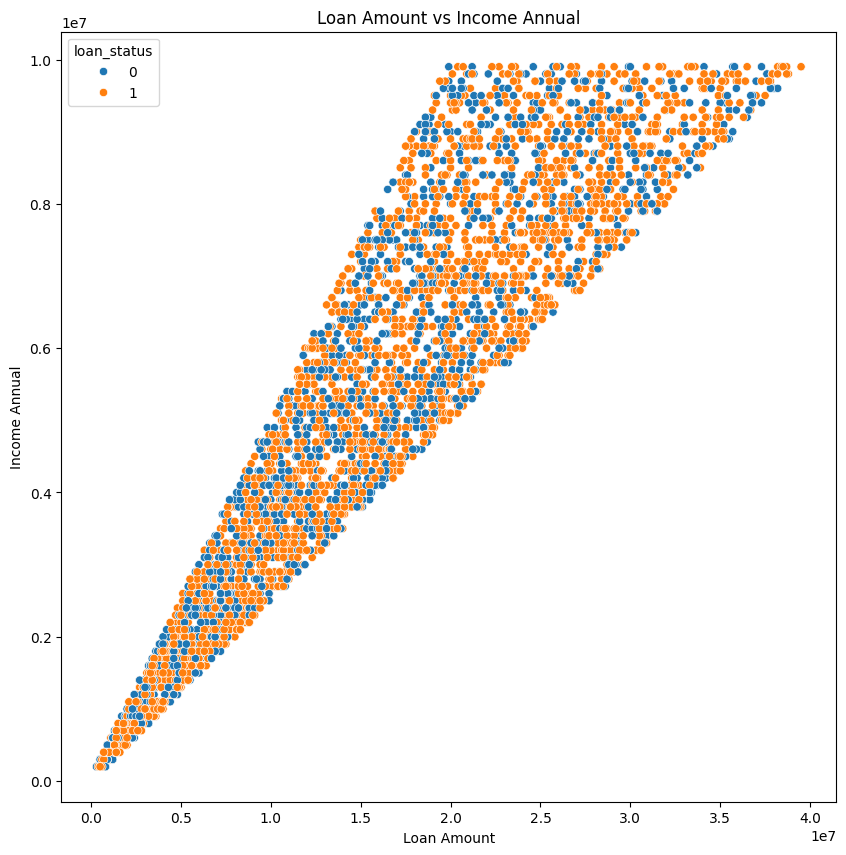

In [ ]:
# plot loan_amount and income_annum, and color will be the loan_status
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=informative_loan_ds["loan_amount"],
    y=informative_loan_ds["income_annum"],
    hue=informative_loan_ds["loan_status"],
)
plt.title("Loan Amount vs Income Annual")
plt.xlabel("Loan Amount")
plt.ylabel("Income Annual")
plt.show()

In the informative dataset we want higher loan_amount for the loan_status=1 users, to make it a more informative feature, so we will multiply it by a factor of 1.3.

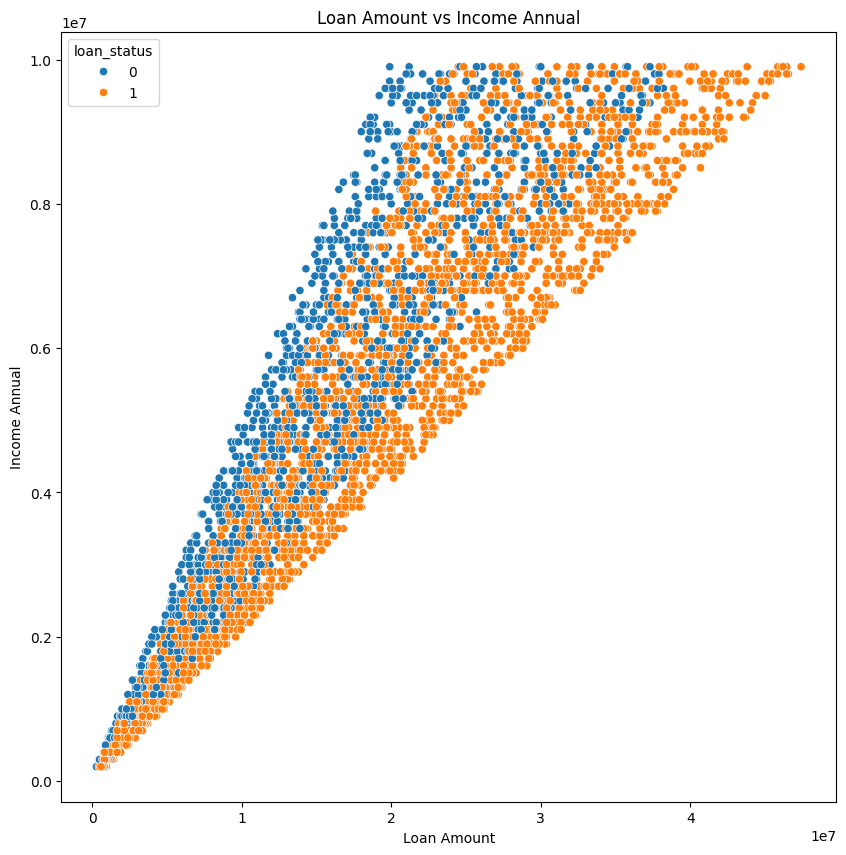

In [ ]:
factor = 1.3
informative_loan_ds["loan_amount"] = informative_loan_ds.apply(
    lambda x: x["loan_amount"] * 1.2 if x["loan_status"] == 1 else x["loan_amount"],
    axis=1,
)


# plot again:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=informative_loan_ds["loan_amount"],
    y=informative_loan_ds["income_annum"],
    hue=informative_loan_ds["loan_status"],
)
plt.title("Loan Amount vs Income Annual")
plt.xlabel("Loan Amount")
plt.ylabel("Income Annual")
plt.show()

Now we can see that loan_amount is indeed informative, as it can seperate some of the data (blue and orange points)

In [ ]:
# train on the informative_loan_ds on loan_amount only
features_cols = ["loan_amount"]
model = get_large_mlp_model(len(features_cols))
threshold = 0.5
model_results = train_on_chosen_features(
    informative_loan_ds, model, features_cols, threshold=threshold
)
print(
    f"Model trained on {features_cols} features has acc: {model_results['metrics']['accuracy']:.2f}"
)

Training model: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]

Model trained on ['loan_amount'] features has acc: 0.63


0.63 using loan_amount only is informative enough, let's make other features to have about the same accuracy.

Make income_annum informative

In [ ]:
# now mul income_annum by factor for loan_status=1 users:

factor = 0.9  # reduce cause negative gradient. So that people with lower income have
# higher chance of getting loan
informative_loan_ds["income_annum"] = informative_loan_ds.apply(
    lambda x: (
        x["income_annum"] * factor if x["loan_status"] == 1 else x["income_annum"]
    ),
    axis=1,
)

# train on the informative_loan_ds on loan_amount only
features_cols = ["income_annum"]
model = get_large_mlp_model(len(features_cols))
threshold = 0.5
model_results = train_on_chosen_features(
    informative_loan_ds, model, features_cols, threshold=threshold
)
print(
    f"Model trained on {features_cols} features has acc: {model_results['metrics']['accuracy']:.2f}"
)

Training model: 100%|██████████| 100/100 [00:03<00:00, 29.20it/s]

Model trained on ['income_annum'] features has acc: 0.67


Make luxury_assets_value informative.

In [ ]:
# luxury_assets_value
factor = 1.4
informative_loan_ds["luxury_assets_value"] = informative_loan_ds.apply(
    lambda x: (
        x["luxury_assets_value"] * factor
        if x["loan_status"] == 1
        else x["luxury_assets_value"]
    ),
    axis=1,
)

# train on the informative_loan_ds on loan_amount only
features_cols = ["luxury_assets_value"]
model = get_large_mlp_model(len(features_cols))
threshold = 0.5
model_results = train_on_chosen_features(
    informative_loan_ds, model, features_cols, threshold=threshold
)
print(
    f"Model trained on {features_cols} features has acc: {model_results['metrics']['accuracy']:.2f}"
)

Training model:  21%|██        | 21/100 [00:00<00:02, 29.26it/s]

Training model: 100%|██████████| 100/100 [00:03<00:00, 29.11it/s]

Model trained on ['luxury_assets_value'] features has acc: 0.63



/Users/hahemthomas/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hahemthomas/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hahemthomas/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

Informative as the others as it gets 0.63 acc!


Let's make cibil_score informative in the same magnitude (by harming its seperability)

In [ ]:
# mul cibil_score by factor for loan_status=1 users:
factor = 0.6
informative_loan_ds["cibil_score"] = informative_loan_ds.apply(
    lambda x: x["cibil_score"] *
    factor if x["loan_status"] == 1 else x["cibil_score"],
    axis=1,
)

# train on the informative_loan_ds on cibil_score only
features_cols = ["cibil_score"]
model = get_large_mlp_model(len(features_cols))
threshold = 0.5
model_results = train_on_chosen_features(
    informative_loan_ds, model, features_cols, threshold=threshold
)
print(
    f"Model trained on {features_cols} features has acc: {model_results['metrics']['accuracy']:.2f}"
)

Training model:  12%|█▏        | 12/100 [00:00<00:02, 30.59it/s]

Training model: 100%|██████████| 100/100 [00:03<00:00, 29.39it/s]

Model trained on ['cibil_score'] features has acc: 0.68


Great, now cibil_score gives 0.67 accuracy, as informative as the others!

In [ ]:
# train on all features
_, _, train_loader, test_loader = prepare_data(informative_loan_ds)
model = get_large_mlp_model(input_size)
threshold = 0.5
model_results = train_and_evaluate_pytorch_model(
    threshold, model, "model", train_loader, test_loader
)
print(
    f"Model trained on all features has acc: {model_results['metrics']['accuracy']:.2f}"
)

Training model: 100%|██████████| 100/100 [00:03<00:00, 28.67it/s]

Model trained on all features has acc: 0.86


To sum up: Now our informative model needs to use/depend on several features to get high accuracy, because when it uses each of the 4 alone it gets ~0.64 accuracy.

### Informed Model Feature Reliability

In this section, we will present algorithms that utilize the strategic vector to make the informed model better. Meaning - we will examine our E Hypothesis.

Important - <b>Now we assume that when the bank started - the data is clean,
and after some time strategists start acting.</b>

Meaning - baseline model and informed model will train on the data before strategies act and will be tested on the noised data (after strategies have been used).

That makes sense as when the bank releases its first model the strategists want to decieve it, therefore, the model trains on clean data but is tested in real life in an environment with strategic users.

### Algorithms

Some of the algos are implemented in strategy_vector_simulation function.

- Drop Algorithm: We will drop from the ds the top k most non reliable features and train the model.

- Aggregation Algorithm: The model will work as follows:
  1. Train k models, the ith model will drop the ith most non-reliable (high strategic magnitude) feature.
  2. Define an aggregator model that will take the outputs of all models.
  3. The aggregator model would predict a probability (logit) that is: 
  A weighted sum, such that the ith model predict probability $p_i$,
  and this prob is weighted with the strategic magnitude of the ith feature it dropped.
  Explanation: The idea is that as it dropped a highly strategic feature (less reliable) we want to give the model more weight because it dropped a high noised feature.
  4. Divide all by the sum of all top k features strategic magnitudes so that the prediction will be between 0 and 1.

Models that we'll not implement:

- A variation of the aggregation algorithm that works as follows: <br>
<u>Input:</u> The algorithm takes one parameter: `num_models_to_aggregate`. <br>
The algorithm will:
  1. Create `num_models_to_aggregate` models to aggregate.
  2. Each model will be created in the following way: iterate through the strategic vector and include each feature in the current model's training with a probability equal to the feature's reliability. This ensures that the models will favor reliable features.
  3. Aggregate the models as previously done, but now the logit weight of model \(i\) will be the sum of the magnitudes of all the strategic features dropped. The weighted sum will be divided by the sum of all model weights to ensure the aggregated prediction will be between 0 and 1.

- Another algorithm we'll not implement: First, train the model on the data. Then decrease the MLP connections of features in the first linear layer, in proportion to their strategy magnitude.

Note: The implementation of the above algorithm is in the code of the second simulation.

### Experiment 4 - Drop Algorithm

Training baseline_model: 100%|██████████| 100/100 [00:03<00:00, 28.90it/s]


Using Drop K=1 Most Strategic Features Algo...
Features to drop: ['luxury_assets_value']
Features to keep: ['commercial_assets_value', 'loan_term', 'self_employed', 'loan_amount', 'no_of_dependents', 'education', 'cibil_score', 'income_annum', 'bank_asset_value', 'residential_assets_value']


Training informed_model: 100%|██████████| 100/100 [00:03<00:00, 28.98it/s]


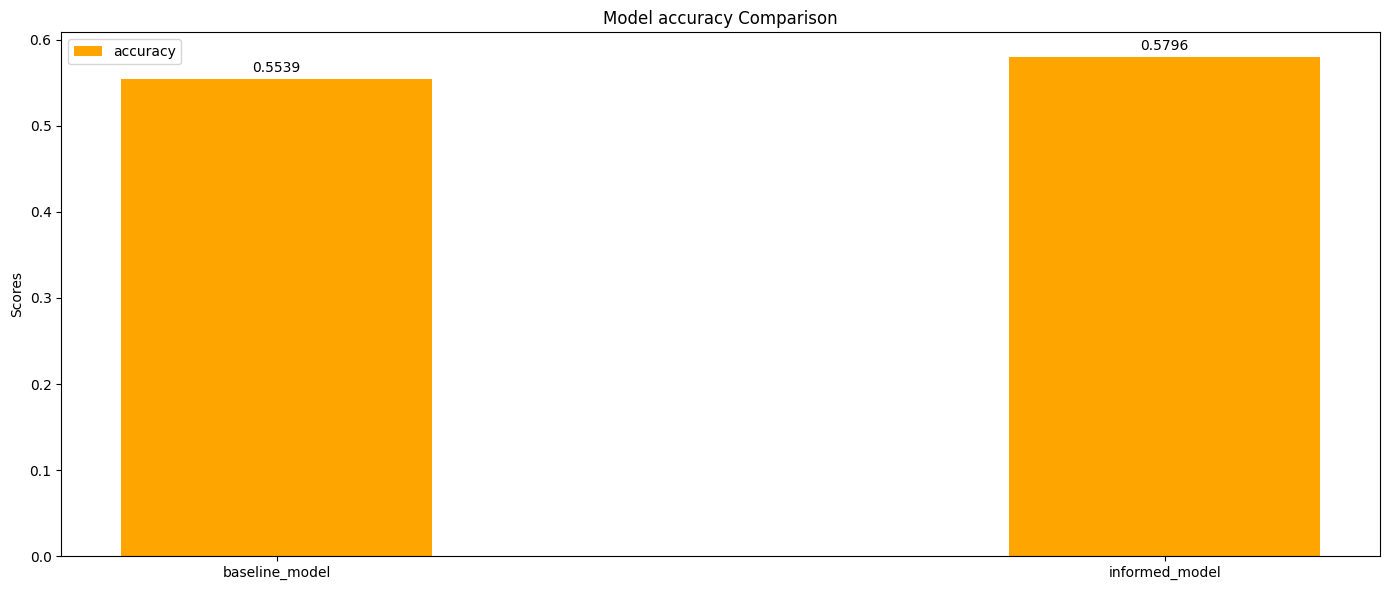

In [ ]:
feature_strategy_vector = {
    # "cibil_score": {"reliability": 0., "sign": -1},  # 0.6
    # loan_amount factor = 1.3. so choose 0.7 reliability will cause 0.3 magnitude that amplify strategists towards people that get loan
    "loan_amount": {"reliability": 0.7, "sign": 1},
    # factor of income_annum = 0.9. minus to go after those got loan users.
    "income_annum": {"reliability": 0.9, "sign": -1},
    # this one will have aggressive strategy so will be dropped by our algo.
    "luxury_assets_value": {"reliability": 0.1, "sign": 1},  # 1.4
}
threshold = 0.5

range_strategists_act = (0.0, threshold)
informed_algo_args = DropKMostStrategicFeaturesAlgoArgs(k=1)
strategy_vector_simulation(
    informative_loan_ds,
    feature_strategy_vector,
    range_strategists_act,
    compare_baseline_and_initial_only=False,
    threshold=threshold,
    informed_algo_args=informed_algo_args,
)

As we can see, the accuracy of the informed model increased in ~5% due to the drop of the top k=1 most non reliable features, which is luxury_assets_value.

That's a realistic example, people can lie about their luxury assets as sport cars etc. If the bank evaluates this feature as the most non-reliable -> the algorithm with k=1 will drop it and therefore improve the model.

This aligns with our E Hypothesis! we managed to utilize the strategy vector to improve the model performance.

Training baseline_model: 100%|██████████| 100/100 [00:03<00:00, 28.95it/s]


Using Drop K=3 Most Strategic Features Algo...
Features to drop: ['luxury_assets_value', 'income_annum', 'loan_amount']
Features to keep: ['commercial_assets_value', 'loan_term', 'self_employed', 'no_of_dependents', 'education', 'cibil_score', 'bank_asset_value', 'residential_assets_value']


Training informed_model: 100%|██████████| 100/100 [00:03<00:00, 27.80it/s]


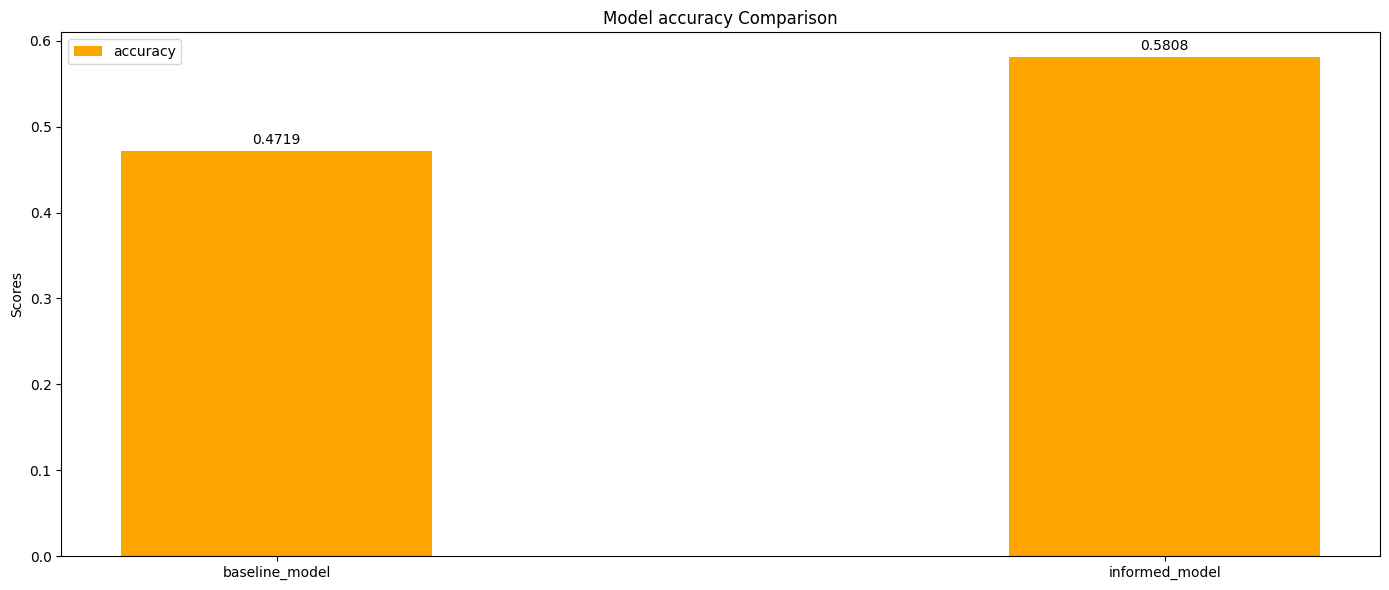

In [ ]:
feature_strategy_vector = {
    "loan_amount": {"reliability": 0.3, "sign": 1},
    "income_annum": {"reliability": 0.2, "sign": -1},
    "luxury_assets_value": {"reliability": 0.1, "sign": 1},  # 1.4
}
threshold = 0.5

range_strategists_act = (0.0, threshold)
# Drop top k=3!
informed_algo_args = DropKMostStrategicFeaturesAlgoArgs(k=3)
strategy_vector_simulation(
    informative_loan_ds,
    feature_strategy_vector,
    range_strategists_act,
    compare_baseline_and_initial_only=False,
    threshold=threshold,
    informed_algo_args=informed_algo_args,
)

Here, we chose 3 strategic features, and k=3 will drop all of them.
Model's accuracy improved by ~8%.

### Experiment 5: Good Bank Evaluation


Hypothesis: If the bank accurately identifies the optimal threshold
𝑘 to eliminate all low-reliability features, the accuracy difference between the baseline model and the informed model will be significant, as the informed model will be trained using only highly reliable features.

We will test it by setting k=2, and make 2 of our informative features not reliable, and 1 of them reliable (loan_amount):


Training baseline_model: 100%|██████████| 100/100 [00:03<00:00, 29.86it/s]


Using Drop K=2 Most Strategic Features Algo...
Features to drop: ['luxury_assets_value', 'income_annum']
Features to keep: ['commercial_assets_value', 'loan_term', 'self_employed', 'loan_amount', 'no_of_dependents', 'education', 'cibil_score', 'bank_asset_value', 'residential_assets_value']


Training informed_model: 100%|██████████| 100/100 [00:03<00:00, 28.57it/s]


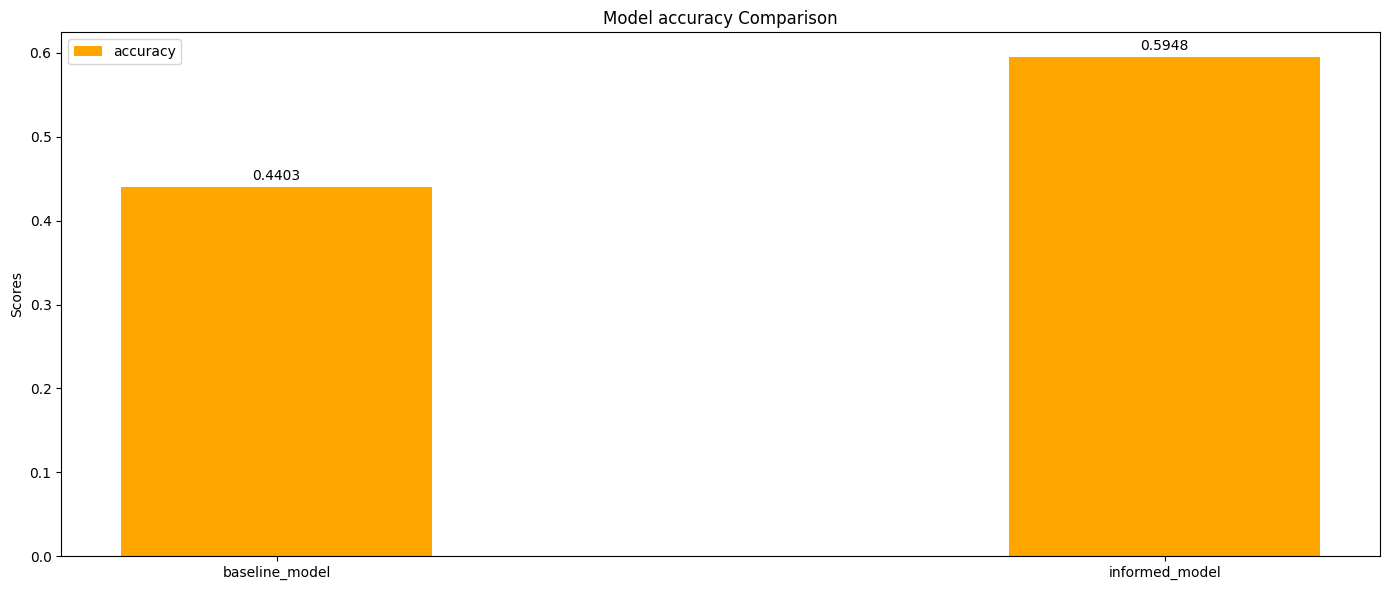

In [ ]:
feature_strategy_vector = {
    "loan_amount": {"reliability": 0.8, "sign": 1},
    "income_annum": {"reliability": 0.2, "sign": -1},
    "luxury_assets_value": {"reliability": 0.1, "sign": 1},  # 1.4
}
threshold = 0.5

range_strategists_act = (0.0, threshold)
informed_algo_args = DropKMostStrategicFeaturesAlgoArgs(k=2)
strategy_vector_simulation(
    informative_loan_ds,
    feature_strategy_vector,
    range_strategists_act,
    compare_baseline_and_initial_only=False,
    threshold=threshold,
    informed_algo_args=informed_algo_args,
)

Indeed, we observed an approximate 16% accuracy difference, indicating that the algorithm is highly sensitive to the threshold
𝑘. Therefore, the bank must carefully select which features to retain for training and which to discard due to low reliability.


### Experiment 6 - Aggregation Algorithm (K=2)

Hypothesis: We expect a good boost when using 2 low reliable features and aggregation with k=2, because each model aggregated is harmed only by 1 unreliable feature, and the aggregation should be more informed:


Training baseline_model: 100%|██████████| 100/100 [00:03<00:00, 29.38it/s]


Using Models Aggregation Algo with K=2...
Top K non-reliable features: ['income_annum', 'luxury_assets_value']
Train model 1 without the 1th most non-reliable feature: income_annum


Training model1_trained_without_income_annum: 100%|██████████| 100/100 [00:03<00:00, 29.01it/s]


Train model 2 without the 2th most non-reliable feature: luxury_assets_value


Training model2_trained_without_luxury_assets_value: 100%|██████████| 100/100 [00:03<00:00, 29.84it/s]


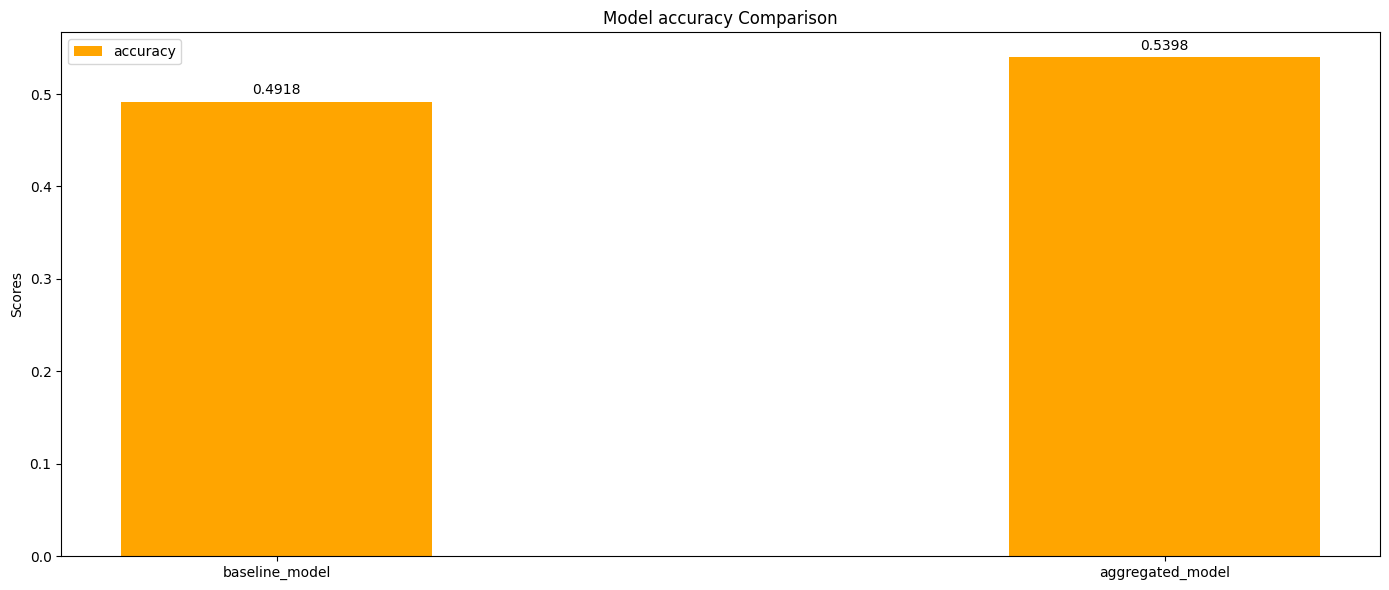

In [ ]:
feature_strategy_vector = {
    "income_annum": {"reliability": 0.1, "sign": -1},
    "luxury_assets_value": {"reliability": 0.2, "sign": 1},  # 1.4
}
threshold = 0.5
range_strategists_act = (0.0, threshold)
informed_algo_args = ModelsAggregationAlgoArgs(k=2)
strategy_vector_simulation(
    informative_loan_ds,
    feature_strategy_vector,
    range_strategists_act,
    compare_baseline_and_initial_only=False,
    threshold=threshold,
    informed_algo_args=informed_algo_args,
)

We can see the informed model have ~5% more accuracy (changes a little bit every run), which aligns with our expectations.

### Experiment 7 - Aggregation Algorithm (K=3)

We expect less improvement than the last experiment if K becomes large (3 in this case).
Reason: Each model aggregator can only drop 1 noised feature, so none of the models are "fully informed".

In the variation suggested each model should be very informed.


Training baseline_model: 100%|██████████| 100/100 [00:03<00:00, 28.73it/s]


Using Models Aggregation Algo with K=3...
Top K non-reliable features: ['income_annum', 'luxury_assets_value', 'loan_amount']
Train model 1 without the 1th most non-reliable feature: income_annum


Training model1_trained_without_income_annum: 100%|██████████| 100/100 [00:03<00:00, 29.16it/s]


Train model 2 without the 2th most non-reliable feature: luxury_assets_value


Training model2_trained_without_luxury_assets_value: 100%|██████████| 100/100 [00:03<00:00, 29.91it/s]


Train model 3 without the 3th most non-reliable feature: loan_amount


Training model3_trained_without_loan_amount: 100%|██████████| 100/100 [00:03<00:00, 29.32it/s]


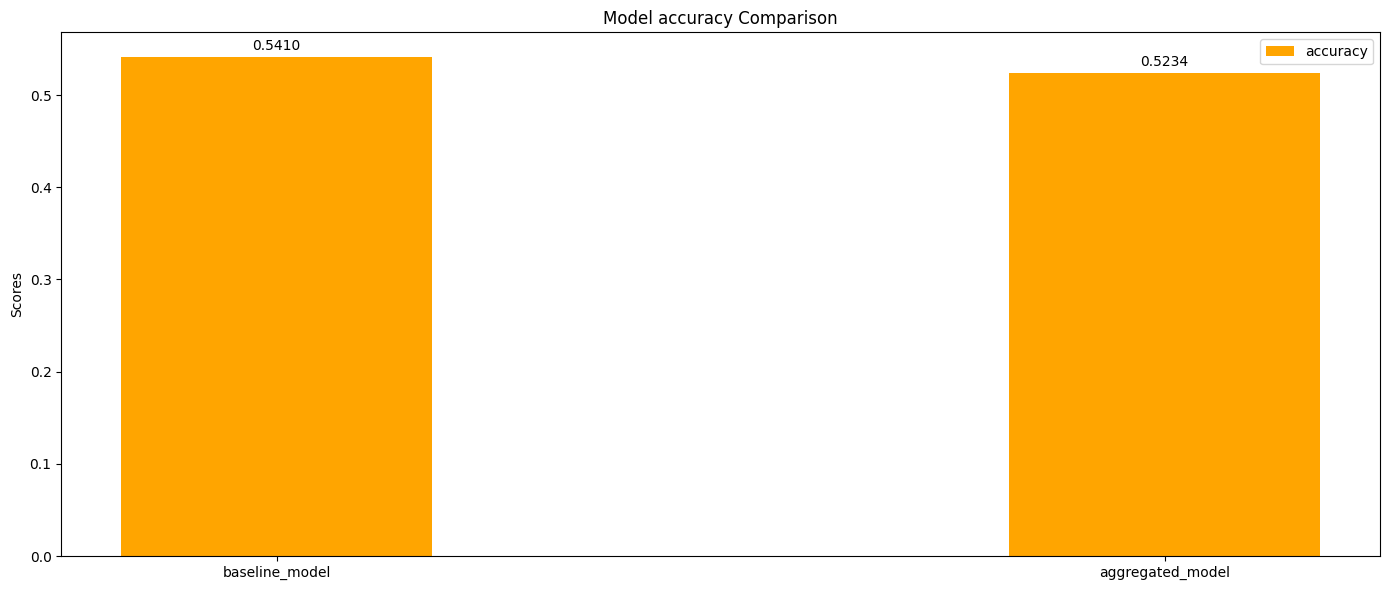

In [ ]:
feature_strategy_vector = {
    "loan_amount": {"reliability": 0.8, "sign": 1},
    "income_annum": {"reliability": 0.1, "sign": -1},
    "luxury_assets_value": {"reliability": 0.2, "sign": 1},  # 1.4
}
threshold = 0.5
range_strategists_act = (0.0, threshold)
informed_algo_args = ModelsAggregationAlgoArgs(k=3)
strategy_vector_simulation(
    informative_loan_ds,
    feature_strategy_vector,
    range_strategists_act,
    compare_baseline_and_initial_only=False,
    threshold=threshold,
    informed_algo_args=informed_algo_args,
)

We can see that the aggregated model got ~3% more accuracy than the baseline one.

We can attribute this small increase to the fact that the aggregator model each time drops only 1 feature and therefore not overcoming the noise.

We think that the aggregator variation algo we presented (that aggregates num_models_to_aggregate each will keep each feature in training with prob=feature reliability) will outperform the base aggregation algo significantly, as it allows different models to drop different number of features, and multiple features (not only 1 per model), so when aggregating the models it will probably have a good prediction that takes into account the strategy in all features together, and not 1 by 1.


# Section 4: Discussion

## What Have We Done?

As we observed, dynamic systems of strategic users will converge to lower performance and the average gradient will become more uniform as the range that strategists act increases and as the strategies become more aggressive.

We confirmed our 5 hypotheses from the beginning of the notebook using many experiments and simulations.

We presented several ways to address the strategic vector utilization problem and demonstrated improvements in models with both the drop features algorithm and the aggregation algorithm.

## Advantages of our Approach

1. Both algorithms we implemented are relatively simple and showed good improvement over the baseline model.
2. Our aggregation algorithm with the variation can generalize to make image models focus on areas in the image when classifying image for example, and with the flexibility to train any k we choose (probably k=2,3,4 because need to train k models) and still take into account all pixel's reliabilities
3. The drop algorithm runs faster than normal training because it executes only once and uses fewer features, so actually it serves also as a "features backward selection"(start with all features and remove top k that are the most non-reliable) regularization that prevents overfit.

## Disadvantages of our Approach

1. We believe that better algorithms could achieve significantly higher improvements.
2. Users often create strategies in important features, but our drop algorithm simply removes these features. In cases like we originally had (before creating the informative dataset), where all the information is in one feature, this algorithm can fail by discarding that critical feature. More generally, it removes strategic features that might be highly informative.
3. Our initial aggregation algorithm cannot be used for high values of \(k\), as the time complexity increases rapidly due to the need to train \(k\) different models.

## Future Directions

1. The aggregation algorithm should undergo some changes, such as the variation we proposed, and test many other variations that allow a general working method that is not sensitive to its parameters, in our case, to the `num_models_to_aggregate` parameter, as it uses probabilities=reliabilities to generate good models on average(Expected value). When aggregated, we converge to a good model because of the strong law of large numbers (converging the Expected model).
2. Researchers could develop models to estimate the features' reliability vector, which may lead to better performance than using the bank "estimated" reliability values.
3. We could extend the presented algorithms or similar ones to image data. For example, we could use the methods we showed (with modifications) to concentrate the model on reliable features, making image models focus on important areas in the image (similar to "reliable features"). If, for instance, we know that the relevant information for the image model is primarily in the center and is circular, we can assign low reliability scores to the background, thus focusing on the circular center.
4. We can extend our aggregation algorithms to images using the variation that allows training even 3 models for example that take into account the reliabilities of all the features in the image.